# readme
descrip: plot geostrohphic mass flux (Vg*PD) and ageostrohphic mass flux (Vag*PD) at surface for reviewer #2 <br>

update history: <br>
v1.0 DL 2022Jan12 <br>
 
extra notes: <br>
for time series files such as UVEL, VVEL, PD <br>
=== HR === <br>
CESM-TNST HR Ens#1 has missing time: 2033-07, 2038-09, 2052-11<br>
CESM-CTRL HR does not have missing UVEL and VVEL<br>

=== LR ===<br>
CESM-TNST LR miss 2014-Jan (2014-02-01 monthly file) from time series file<br>
CESM-CTRL LR miss 0374-09, 0398-12, 0417-02, 0445-06, 0401-11 from time series file <br>

# import modules

In [1]:
# general python packages
import numpy as np
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
import xgcm
import pop_tools
# import xoak
# import xesmf as xe
import seawater 

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.3.173:38908")
client

<Client: 'tcp://10.73.3.173:38908' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200, 700 
nlat1_r_t12, nlat2_r_t12 = 1300, 2000

nlon1_r_g16, nlon2_r_g16 = 260, 321
nlat1_r_g16, nlat2_r_g16 = 230, 350

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55
# ===========================================================

z = 15*100 # 15 m 
g = 9.8 # gravity acceleration
# rho0 = 1035 # reference density, see Fox-Kemper and Ferrari (2008) Table 1
omega = 7.29e-5 # Earths Angular Velocity, [rad/s], from POP model output
# deg2rad, rad2deg = np.pi/180.0,  180.0/np.pi # Angle conversions 

# time2 = np.arange(2001,2100+1,1)

chunks_HR = {'nlat':400,'nlon':300}
chunks_LR = {'nlat':384,'nlon':320/4,'time':12}

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'VgPD_USEastCoastCESM4reviewer2_2022Jan11.png'
pic2 = outdir + 'VagPD_USEastCoastCESM4reviewer2_2022Jan11.png'

In [4]:
# function to compute gradient 
# copied by DL on 2022Jan07 from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb

def x_gradh(F, grid):
    """
    gradient of scalar xgcm_metrics
    for pop
    """
    F_yi = grid.interp(F, axis="Y", boundary="extend")  # 0.5*(F[i,j+1]+F[i,j])
    F_xi = grid.interp(F, axis="X", boundary="extend")  # 0.5*(F[i+1,j]+F[i,j])
    dFdx = grid.derivative(F_yi, axis="X", boundary="extend")
    dFdy = grid.derivative(F_xi, axis="Y", boundary="extend")
    return dFdx, dFdy

# read files

In [5]:
# read ssh TH

# --- infiles below return error when converting them to xgcm object (do not use) --- 
# infile_ssh_TH = ('/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
#                  'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
# infile0_ssh_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.200601-201512.nc')
# infile0_ssh_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/SSH/'
#                   'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.nday1.SSH.200001-200611.nc')

# ds_ssh_TH = xr.open_dataset(infile_ssh_TH, chunks={'nlat':400,'nlon':300})
# ds0_ssh_TH = xr.open_dataset(infile0_ssh_TH, chunks={'nlat':400,'nlon':300})
# ds_ssh_TH
# -----------------------------------------------------------------------------------

infile1_ssh_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/SSH/'
                  'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.nday1.SSH.200001-200611.nc')

indir2_ssh_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/')
infiles2_ssh_TH = sorted(glob.glob(indir2_ssh_TH + 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop*'))
print('first file: ', infiles2_ssh_TH[0])
print('last file: ', infiles2_ssh_TH[-1])

ds1_ssh_TH_raw = xr.open_dataset(infile1_ssh_TH, chunks=chunks_HR)
ds1_ssh_TH = ds1_ssh_TH_raw.sel(time=slice('2001-02','2006-01'))
print('ds1_ssh_TH first time: ', ds1_ssh_TH.time[0].values)
print('ds1_ssh_TH end time: ', ds1_ssh_TH.time[-1].values)

ds2_ssh_TH = xr.open_mfdataset(infiles2_ssh_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)
print('ds2_ssh_TH first time: ', ds2_ssh_TH.time[0].values)
print('ds2_ssh_TH end time: ', ds2_ssh_TH.time[-1].values)
ds_ssh_TH = xr.concat([ds1_ssh_TH, ds2_ssh_TH], dim="time")
# ds_ssh_TH

first file:  /ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.200601-201512.nc
last file:  /ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SSH/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.209601-210202.nc
ds1_ssh_TH first time:  2001-02-01 00:00:00
ds1_ssh_TH end time:  2006-01-01 00:00:00
ds2_ssh_TH first time:  2006-02-01 00:00:00
ds2_ssh_TH end time:  2101-01-01 00:00:00


In [6]:
# read ssh CH
indir_ssh_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/SSH/')
infiles_ssh_CH = sorted(glob.glob(indir_ssh_CH + 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.04*'))
infile1_ssh_CH = indir_ssh_CH + 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.050001-050912.nc'
infiles_ssh_CH.append(infile1_ssh_CH)
print('first file: ', infiles_ssh_CH[0])
print('last file: ', infiles_ssh_CH[-1])

ds_ssh_CH_raw = xr.open_mfdataset(infiles_ssh_CH, compat="override", combine="by_coords", 
                                  data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)
print('ds2_ssh_CH_raw first time: ', ds_ssh_CH_raw.time[0].values)
print('ds2_ssh_CH_raw end time: ', ds_ssh_CH_raw.time[-1].values)

ds_ssh_CH = ds_ssh_CH_raw.isel(time=slice(12,-9*12))
print('ds2_ssh_CH first time: ', ds_ssh_CH.time[0].values)
print('ds2_ssh_CH end time: ', ds_ssh_CH.time[-1].values)
print('ds2_ssh_CH # time: ', len(ds_ssh_CH.time))

# ds_ssh_CH

first file:  /ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/SSH/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.040001-040912.nc
last file:  /ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/SSH/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.nday1.SSH.050001-050912.nc
ds2_ssh_CH_raw first time:  0400-02-01 00:00:00
ds2_ssh_CH_raw end time:  0510-01-01 00:00:00
ds2_ssh_CH first time:  0401-02-01 00:00:00
ds2_ssh_CH end time:  0501-01-01 00:00:00
ds2_ssh_CH # time:  1200


In [7]:
# read ssh TL
infile_ssh_TL = ('/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
                 'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.SSH.185001.210012.nc')
ds_ssh_TL_raw = xr.open_dataset(infile_ssh_TL, chunks=chunks_LR)
ds_ssh_TL = ds_ssh_TL_raw.sel(time=slice('2001-01','2100-12'))

print('ds_ssh_TL first time: ', ds_ssh_TL.time[0].values)
print('ds_ssh_TL end time: ', ds_ssh_TL.time[-1].values)
print('ds_ssh_TL # time: ', len(ds_ssh_TL.time))

# ds_ssh_TL

ds_ssh_TL first time:  2001-01-17 00:00:00
ds_ssh_TL end time:  2100-12-17 00:00:00
ds_ssh_TL # time:  1200


In [8]:
infile_ssh_CL = ('/ihesp/archive/Sunway_Runs/LR_PI_CTRL/'
                 'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.SSH.000101.050012.nc')
ds_ssh_CL_raw = xr.open_dataset(infile_ssh_CL, chunks=chunks_LR)
print('ds_ssh_CL_raw time[0]', ds_ssh_CL_raw.time[0].values)
print('ds_ssh_CL_raw time[-1]', ds_ssh_CL_raw.time[-1].values)
# 250-->1850, 500-->2100
# 1-->1621, # 1850-(250-1)=1601
# time_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M')
# 2101-01 is not included, the last time is 2100-12
# ds_CL = ds_CL_raw.sel(time=slice(400))
# ds_CL = ds_CL_raw.assign_coords(time=time_CL)
ds_ssh_CL = ds_ssh_CL_raw.sel(time=slice('0401','0500'))
print('ds_ssh_CL time[0]', ds_ssh_CL.time[0].values)
print('ds_ssh_CL time[-1]', ds_ssh_CL.time[-1].values)
print('ds_ssh_CL # time', len(ds_ssh_CL.time))
# ds_ssh_CL

ds_ssh_CL_raw time[0] 0001-02-01 00:00:00
ds_ssh_CL_raw time[-1] 0500-12-17 00:00:00
ds_ssh_CL time[0] 0401-01-17 00:00:00
ds_ssh_CL time[-1] 0500-12-17 00:00:00
ds_ssh_CL # time 1200


In [9]:
# read U, V vel TH 

# --- read one file ---
# infile_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-200612.nc')
# ds_uvel_TH = xr.open_dataset(infile_uvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_uvel_TH

# infile_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-200612.nc')
# ds_vvel_TH = xr.open_dataset(infile_vvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_vvel_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_vvel_TH first time: ', ds_vvel_TH.time[0].values)
print('ds_vvel_TH end time: ', ds_vvel_TH.time[-1].values)
print('ds_vvel_TH # time: ', len(ds_vvel_TH.time))
#ds_vvel_TH

ds_vvel_TH first time:  2001-02-01 00:00:00
ds_vvel_TH end time:  2101-01-01 00:00:00
ds_vvel_TH # time:  1200


In [10]:
# read CH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_CH = np.arange(401,500+1) 
prefix1a_CH = 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.'

indir1a_uvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/UVEL/')
infiles1a_uvel_CH = [indir1a_uvel_CH + prefix1a_CH + 'UVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
                     for iyr in yrs1a_CH]
infiles1a_uvel_CH

indir1a_vvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/VVEL/')
infiles1a_vvel_CH = [indir1a_vvel_CH + prefix1a_CH + 'VVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
               for iyr in yrs1a_CH]
infiles1a_vvel_CH

ds_uvel_CH = xr.open_mfdataset(infiles1a_uvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_CH = xr.open_mfdataset(infiles1a_vvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

print('ds_vvel_CH first time: ', ds_vvel_CH.time[0].values)
print('ds_vvel_CH end time: ', ds_vvel_CH.time[-1].values)
print('ds_vvel_CH # time: ', len(ds_vvel_CH.time))
# ds_vvel_CH 

ds_vvel_CH first time:  0401-02-01 00:00:00
ds_vvel_CH end time:  0501-01-01 00:00:00
ds_vvel_CH # time:  1200


In [11]:
# read U, V TL
infile1_uvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                   'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.UVEL.185001-200512.nc')
infile1_vvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                   'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.VVEL.185001-200512.nc')

infile2_uvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
                   'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-210512.nc')
infile2_vvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
                   'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-210512.nc')

ds_uvel_TL_raw = xr.open_mfdataset([infile1_uvel_TL, infile2_uvel_TL], compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)

ds_vvel_TL_raw = xr.open_mfdataset([infile1_vvel_TL, infile2_vvel_TL], compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)

# === 2022Jan10 directly selecting time (codes below) returns errors due to different calendar types === 
# ds_uvel_TL = ds_uvel_TL_raw.sel(time=slice('2001-01','2101-01'))
# TypeError: cannot compare cftime.datetime(1978, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True) and 
#     cftime.datetime(2001, 1, 1, 0, 0, 0, 0, calendar='gregorian', has_year_zero=False)
# ========================================================================================

# 2001-1850=151 yr, 2100-2001+1=100 yr
time_vvel_s_TL = ds_vvel_TL_raw.time.to_pandas().index.shift(-1,'D') # shift it one month back 
ds_uvel_TL = ds_uvel_TL_raw.assign_coords(time=time_vvel_s_TL).sel(time=slice('2001','2100'))
ds_vvel_TL = ds_vvel_TL_raw.assign_coords(time=time_vvel_s_TL).sel(time=slice('2001','2100'))

print('ds_vvel_TL first time: ', ds_vvel_TL.time[0].values)
print('ds_vvel_TL end time: ', ds_vvel_TL.time[-1].values)
print('ds_vvel_TL # time: ', len(ds_vvel_TL.time)) # miss 2014-Jan (2014-02-01 monthly file) from vvel data file

# ds_uvel_TL

ds_vvel_TL first time:  2001-01-31 00:00:00
ds_vvel_TL end time:  2100-12-31 00:00:00
ds_vvel_TL # time:  1199


In [12]:
# read U, V CL
infile_uvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                  'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.UVEL.25001-50112.nc')
infile_vvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
                  'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.VVEL.25001-50112.nc')
ds_uvel_CL_raw = xr.open_dataset(infile_uvel_CL, chunks=chunks_LR)
ds_vvel_CL_raw = xr.open_dataset(infile_vvel_CL, chunks=chunks_LR)
ds_uvel_CL = ds_uvel_CL_raw.sel(time=slice('0401-02','0501-01'))
ds_vvel_CL = ds_vvel_CL_raw.sel(time=slice('0401-02','0501-01'))

print('ds_vvel_CL first time: ', ds_vvel_CL.time[0].values)
print('ds_vvel_CL end time: ', ds_vvel_CL.time[-1].values)
print('ds_vvel_CL # time: ', len(ds_vvel_CL.time)) 
# miss 0417-02, 0445-06, 0401-11 three monthly data files
# ds_vvel_CL

ds_vvel_CL first time:  0401-02-01 00:00:00
ds_vvel_CL end time:  0501-01-01 00:00:00
ds_vvel_CL # time:  1197


In [13]:
# read moc TL
infile_MOC_TL = ('/ihesp/archive/Sunway_Runs/LR_HF_TNST/'
                 'B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
ds_MOC_TL_raw = xr.open_dataset(infile_MOC_TL) # , chunks={'moc_z':1}
time_s_TL = ds_MOC_TL_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_TL = ds_MOC_TL_raw.assign_coords(time=time_s_TL).sel(time=slice('1850','2100'))
print('ds_MOC_TL.time[0]', ds_MOC_TL.time[0].values)
print('ds_MOC_TL.time[-1]', ds_MOC_TL.time[-1].values)
print('len(ds_MOC_TL.time)', len(ds_MOC_TL.time))
ds_MOC_TL

ds_MOC_TL.time[0] 1850-01-31 00:00:00
ds_MOC_TL.time[-1] 2100-12-31 00:00:00
len(ds_MOC_TL.time) 3012


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp) |S256 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [14]:
# read moc CL
infile_MOC_CL = ('/ihesp/archive/Sunway_Runs/LR_PI_CTRL/'
                 'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.MOC.000101.050012.nc')
ds_MOC_CL_raw = xr.open_dataset(infile_MOC_CL) # , chunks={'moc_z':1}
time_s_CL = ds_MOC_CL_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_CL = ds_MOC_CL_raw.assign_coords(time=time_s_CL).sel(time=slice('0250','0500'))
print('ds_MOC_CL.time[0]', ds_MOC_CL.time[0].values)
print('ds_MOC_CL.time[-1]', ds_MOC_CL.time[-1].values)
print('len(ds_MOC_CL.time)', len(ds_MOC_CL.time))
ds_MOC_CL

ds_MOC_CL.time[0] 0250-01-31 00:00:00
ds_MOC_CL.time[-1] 0500-12-31 00:00:00
len(ds_MOC_CL.time) 3012


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 0250-01-31 00:00:00 ... 0500-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, nchar, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp, nchar) |S1 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [15]:
# read moc TH
infile_MOC_TH = ('/ihesp/archive/Sunway_Runs/HR_HF_TNST/'
                 'B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.MOC.185001.210012.nc')
ds_MOC_TH_raw = xr.open_dataset(infile_MOC_TH) # , chunks={'moc_z':1}
time_s_TH = ds_MOC_TH_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_TH = ds_MOC_TH_raw.assign_coords(time=time_s_TH).sel(time=slice('1850','2100'))
print('ds_MOC_TH.time[0]', ds_MOC_TH.time[0].values)
print('ds_MOC_TH.time[-1]', ds_MOC_TH.time[-1].values)
print('len(ds_MOC_TH.time)', len(ds_MOC_TH.time))
ds_MOC_TH

ds_MOC_TH.time[0] 1850-01-31 00:00:00
ds_MOC_TH.time[-1] 2100-12-31 00:00:00
len(ds_MOC_TH.time) 3012


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [16]:
# read moc CH
infile_MOC_CH = ('/ihesp/archive/Sunway_Runs/HR_PI_CTRL/'
                 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.MOC.002101.050112.nc')
ds_MOC_CH_raw = xr.open_dataset(infile_MOC_CH) # , chunks={'moc_z':1}
time_s_CH = ds_MOC_CH_raw.time.to_pandas().index.shift(-1,'D')
ds_MOC_CH = ds_MOC_CH_raw.assign_coords(time=time_s_CH).sel(time=slice('0250','0500'))
print('ds_MOC_CH.time[0]', ds_MOC_CH.time[0].values)
print('ds_MOC_CH.time[-1]', ds_MOC_CH.time[-1].values)
print('len(ds_MOC_CH.time)', len(ds_MOC_CH.time))
ds_MOC_CH

ds_MOC_CH.time[0] 0250-01-31 00:00:00
ds_MOC_CH.time[-1] 0500-12-31 00:00:00
len(ds_MOC_CH.time) 3012


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 0250-01-31 00:00:00 ... 0500-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [17]:
infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds_t12 = xr.open_dataset(infile_t12)
ds_t12

infile_3dDZT_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZT_SY_2021Nov04.nc') 
ds_3dDZT_t12 = xr.open_dataset(infile_3dDZT_t12)
ds_3dDZT_t12

infile_3dDZU_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZU_SY_2021Nov04.nc') 
ds_3dDZU_t12 = xr.open_dataset(infile_3dDZU_t12)
ds_3dDZU_t12

infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds_g16 = xr.open_dataset(infile_g16)
ds_g16

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
    TLAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ULAT         (nlat, nlon) float64 ...
    ULONG        (nlat, nlon) float64 ...
    DXT          (nlat, nlon) float64 ...
    DYT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    KMT          (nlat, nlon) int32 ...
    REGION_MASK  (nlat, nlon) int32 ...
    dz           (z_t) float64 ...
Attributes:
    lateral_dims:         [384 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ie...
    topography_fname:     inputdata/ocn/pop/gx1v6/grid/topography_20090204.ie...
    region_mask_fname:    inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.i...
    type:                 dipole
    region_mask_regions:  {'Caspian Sea': -14, 'Black Sea': -13, 'Baltic Sea'...
    title:                POP_gx1v6 grid

# data analysis

In [18]:
# make TH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_ssh_TH.time[0].values, ds_ssh_TH.time[-1].values, len(ds_ssh_TH.time)) 
print(ds_uvel_TH.time[0].values, ds_uvel_TH.time[-1].values, len(ds_uvel_TH.time)) 
# print(ds_pd_TH.time[0].values, ds_pd_TH.time[-1].values, len(ds_pd_TH.time)) 

time_vvel_s_TH = ds_uvel_TH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
print(time_vvel_s_TH)

ds_ssh_TH = ds_ssh_TH.assign_coords(time=time_vvel_s_TH)
# ds_pd_TH = ds_pd_TH.assign_coords(time=time_vvel_s_TH)
ds_uvel_TH = ds_uvel_TH.assign_coords(time=time_vvel_s_TH)
ds_vvel_TH = ds_vvel_TH.assign_coords(time=time_vvel_s_TH)

2001-02-01 00:00:00 2101-01-01 00:00:00 1200
2001-02-01 00:00:00 2101-01-01 00:00:00 1200
CFTimeIndex([2001-01-31 00:00:00, 2001-02-28 00:00:00, 2001-03-31 00:00:00,
             2001-04-30 00:00:00, 2001-05-31 00:00:00, 2001-06-30 00:00:00,
             2001-07-31 00:00:00, 2001-08-31 00:00:00, 2001-09-30 00:00:00,
             2001-10-31 00:00:00,
             ...
             2100-03-31 00:00:00, 2100-04-30 00:00:00, 2100-05-31 00:00:00,
             2100-06-30 00:00:00, 2100-07-31 00:00:00, 2100-08-31 00:00:00,
             2100-09-30 00:00:00, 2100-10-31 00:00:00, 2100-11-30 00:00:00,
             2100-12-31 00:00:00],
            dtype='object', length=1200, calendar='noleap', freq='M')


In [19]:
# make CH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_ssh_CH.time[0].values, ds_ssh_CH.time[-1].values, len(ds_ssh_CH.time)) 
print(ds_uvel_CH.time[0].values, ds_uvel_CH.time[-1].values, len(ds_uvel_CH.time)) 
# print(ds_pd_CH.time[0].values, ds_pd_CH.time[-1].values, len(ds_pd_CH.time)) 

time_vvel_s_CH = ds_uvel_CH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
print(time_vvel_s_CH)

ds_ssh_CH = ds_ssh_CH.assign_coords(time=time_vvel_s_CH)
# ds_pd_CH = ds_pd_CH.assign_coords(time=time_vvel_s_CH)
ds_uvel_CH = ds_uvel_CH.assign_coords(time=time_vvel_s_CH)
ds_vvel_CH = ds_vvel_CH.assign_coords(time=time_vvel_s_CH)

0401-02-01 00:00:00 0501-01-01 00:00:00 1200
0401-02-01 00:00:00 0501-01-01 00:00:00 1200
CFTimeIndex([0401-01-31 00:00:00, 0401-02-28 00:00:00, 0401-03-31 00:00:00,
             0401-04-30 00:00:00, 0401-05-31 00:00:00, 0401-06-30 00:00:00,
             0401-07-31 00:00:00, 0401-08-31 00:00:00, 0401-09-30 00:00:00,
             0401-10-31 00:00:00,
             ...
             0500-03-31 00:00:00, 0500-04-30 00:00:00, 0500-05-31 00:00:00,
             0500-06-30 00:00:00, 0500-07-31 00:00:00, 0500-08-31 00:00:00,
             0500-09-30 00:00:00, 0500-10-31 00:00:00, 0500-11-30 00:00:00,
             0500-12-31 00:00:00],
            dtype='object', length=1200, calendar='noleap', freq='M')


In [20]:
# make TL time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
# CESM-TNST LR miss 2014-Jan (2014-02-01 monthly file) from time series file 
ds_ssh_TL = ds_ssh_TL.drop_sel(time = ds_ssh_TL.sel(time='2014-01').time)

print(ds_ssh_TL.time[0].values, ds_ssh_TL.time[-1].values, len(ds_ssh_TL.time)) 
print(ds_uvel_TL.time[0].values, ds_uvel_TL.time[-1].values, len(ds_uvel_TL.time)) 
# print(ds_pd_TL.time[0].values, ds_pd_TL.time[-1].values, len(ds_pd_TL.time)) 

ds_ssh_TL = ds_ssh_TL.assign_coords(time=ds_uvel_TL.time)
# ds_pd_TL = ds_pd_TL.assign_coords(time=ds_uvel_TL.time)

2001-01-17 00:00:00 2100-12-17 00:00:00 1199
2001-01-31 00:00:00 2100-12-31 00:00:00 1199


In [21]:
# make CL time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
# CESM-CTRL LR miss 0374-09, 0398-12, 0417-02, 0445-06, 0401-11 from time series file 

ds_ssh_CL = ds_ssh_CL.drop_sel(time = ds_ssh_CL.sel(time='0401-11').time)
ds_ssh_CL = ds_ssh_CL.drop_sel(time = ds_ssh_CL.sel(time='0417-02').time)
ds_ssh_CL = ds_ssh_CL.drop_sel(time = ds_ssh_CL.sel(time='0445-06').time)

print(ds_ssh_CL.time[0].values, ds_ssh_CL.time[-1].values, len(ds_ssh_CL.time)) 
print(ds_uvel_CL.time[0].values, ds_uvel_CL.time[-1].values, len(ds_uvel_CL.time)) 
# print(ds_pd_CL.time[0].values, ds_pd_CL.time[-1].values, len(ds_pd_CL.time)) 

time_uvel_s_CL = ds_uvel_CL.time.to_pandas().index.shift(-1,'D') # shift it one month back 
print(time_uvel_s_CL)

ds_uvel_CL = ds_uvel_CL.assign_coords(time=time_uvel_s_CL)
ds_vvel_CL = ds_vvel_CL.assign_coords(time=time_uvel_s_CL)
ds_ssh_CL = ds_ssh_CL.assign_coords(time=time_uvel_s_CL)
# ds_pd_CL = ds_pd_CL.assign_coords(time=ds_uvel_CL.time)

# print(ds_temp_TL.time[0].values, ds_temp_TL.time[-1].values, len(ds_temp_TL.time)) 
# ds_uvel_TL.sel(time='2014').time
# ds_ssh_TL.sel(time='2014-01').time

0401-01-17 00:00:00 0500-12-17 00:00:00 1197
0401-02-01 00:00:00 0501-01-01 00:00:00 1197
CFTimeIndex([0401-01-31 00:00:00, 0401-02-28 00:00:00, 0401-03-31 00:00:00,
             0401-04-30 00:00:00, 0401-05-31 00:00:00, 0401-06-30 00:00:00,
             0401-07-31 00:00:00, 0401-08-31 00:00:00, 0401-09-30 00:00:00,
             0401-10-31 00:00:00,
             ...
             0500-03-31 00:00:00, 0500-04-30 00:00:00, 0500-05-31 00:00:00,
             0500-06-30 00:00:00, 0500-07-31 00:00:00, 0500-08-31 00:00:00,
             0500-09-30 00:00:00, 0500-10-31 00:00:00, 0500-11-30 00:00:00,
             0500-12-31 00:00:00],
            dtype='object', length=1197, calendar='noleap', freq='None')


In [22]:
# add DXT, DXU, etc in ds_SSH_TH, need that to convert to xgcm object
# ds_ssh_TH["DXT"] = ds0_ssh_TH.DXT # cm
# ds_ssh_TH["DXU"] = ds0_ssh_TH.DXU # cm
# ds_ssh_TH["DYT"] = ds0_ssh_TH.DYT # cm
# ds_ssh_TH["DYU"] = ds0_ssh_TH.DYU # cm
# ds_ssh_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
# ds_ssh_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# ds_ssh_TH["TAREA"] = ds0_ssh_TH.TAREA # cm
# ds_ssh_TH["UAREA"] = ds0_ssh_TH.UAREA # cm

# ds_ssh_TH["DXT"] = ds_ssh_TH.DXT # cm
# ds_ssh_TH["DXU"] = ds_ssh_TH.DXU # cm
# ds_ssh_TH["DYT"] = ds_ssh_TH.DYT # cm
# ds_ssh_TH["DYU"] = ds_ssh_TH.DYU # cm
ds_ssh_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_ssh_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# ds_ssh_TH["TAREA"] = ds_ssh_TH.TAREA # cm
# ds_ssh_TH["UAREA"] = ds_ssh_TH.UAREA # cm

ds_uvel_TH["VVEL"] = ds_vvel_TH.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_TH["PD"] = ds_pd_TH.PD
ds_uvel_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_uvel_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm

# ds_ssh_CH["DXT"] = ds_ssh_CH.DXT # cm
# ds_ssh_CH["DXU"] = ds_ssh_CH.DXU # cm
# ds_ssh_CH["DYT"] = ds_ssh_CH.DYT # cm
# ds_ssh_CH["DYU"] = ds_ssh_CH.DYU # cm
ds_ssh_CH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_ssh_CH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
# ds_ssh_CH["TAREA"] = ds_ssh_CH.TAREA # cm
# ds_ssh_CH["UAREA"] = ds_ssh_CH.UAREA # cm

ds_uvel_CH["VVEL"] = ds_vvel_CH.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_CH["PD"] = ds_pd_CH.PD
ds_uvel_CH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_uvel_CH["DZU"] = ds_3dDZU_t12.DZU*100 # cm

ds_ssh_TH

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
    TLAT                (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    TLONG               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ULAT                (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    ULONG               (nlat, nlon) float64 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
  * time                (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:0...
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/53)
    ANGLE               (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    ANGLET              (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DXT                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DXU                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DYT                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    DYU                 (time, nlat, nlon) float64 dask.array<chunksize=(60, 400, 300), meta=np.ndarray>
    ...                  ...
    sound               (time) float64 1.5e+05 1.5e+05 ... 1.5e+05 1.5e+05
    stefan_boltzmann    (time) float64 5.67e-08 5.67e-08 ... 5.67e-08 5.67e-08
    time_bound          (time, d2) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    vonkar              (time) float64 0.4 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    DZT                 (z_t, nlat, nlon) float64 nan nan nan ... nan nan nan
    DZU                 (z_t, nlat, nlon) float64 nan nan nan ... nan nan nan
Attributes: (12/14)
    title:                      B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:                    Mon Aug 30 17:53:01 2021: ncap2 -A -s time=ud...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     CCSM POP2, the CCSM Ocean Component
    revision:                   $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlev...
    ...                         ...
    cell_methods:               cell_methods = time: mean ==> the variable va...
    nsteps_total:               2296931
    tavg_sum:                   2678400.0
    tavg_sum_qflux:             2678400.0
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...
    history_of_appended_files:  Mon Aug 30 15:43:41 2021: Appended file time_...

In [23]:
# add DXT, DXU, etc in ds_SSH_TL, need that to convert to xgcm object
# repmat 1d dzt array to 3d array, codes below are copied from heat_budget_Global_FOSI.ipynb of Who Kim
dzt_3d_LR = xr.DataArray(ds_uvel_TL.dz.values[:,None,None]*np.ones((len(ds_uvel_TL.dz), len(ds_uvel_TL.nlat), len(ds_uvel_TL.nlon))), 
                         dims=['z_t','nlat','nlon'], coords={'z_t':ds_uvel_TL.z_t, 'nlat':ds_uvel_TL.nlat, 'nlon':ds_uvel_TL.nlon})

ds_ssh_TL["DXT"] = ds_uvel_TL.DXT # cm
ds_ssh_TL["DXU"] = ds_uvel_TL.DXU # cm
ds_ssh_TL["DYT"] = ds_uvel_TL.DYT # cm
ds_ssh_TL["DYU"] = ds_uvel_TL.DYU # cm
ds_ssh_TL["DZT"] = dzt_3d_LR # cm
ds_ssh_TL["DZU"] = dzt_3d_LR # cm
ds_ssh_TL["TAREA"] = ds_uvel_TL.TAREA # cm
ds_ssh_TL["UAREA"] = ds_uvel_TL.UAREA # cm

ds_uvel_TL["VVEL"] = ds_vvel_TL.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_TL["PD"] = ds_pd_TL.PD
ds_uvel_TL["DZT"] = dzt_3d_LR # cm
ds_uvel_TL["DZU"] = dzt_3d_LR # cm

ds_ssh_CL["DXT"] = ds_uvel_CL.DXT # cm
ds_ssh_CL["DXU"] = ds_uvel_CL.DXU # cm
ds_ssh_CL["DYT"] = ds_uvel_CL.DYT # cm
ds_ssh_CL["DYU"] = ds_uvel_CL.DYU # cm
ds_ssh_CL["DZT"] = dzt_3d_LR # cm
ds_ssh_CL["DZU"] = dzt_3d_LR # cm
ds_ssh_CL["TAREA"] = ds_uvel_CL.TAREA # cm
ds_ssh_CL["UAREA"] = ds_uvel_CL.UAREA # cm

ds_uvel_CL["VVEL"] = ds_vvel_CL.VVEL # add vvel to ds_uvel, so only need to conver to xgcm object once
# ds_uvel_CL["PD"] = ds_pd_CL.PD
ds_uvel_CL["DZT"] = dzt_3d_LR # cm
ds_uvel_CL["DZU"] = dzt_3d_LR # cm

ds_ssh_TL

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 1199, z_t: 60)
Coordinates:
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 ... 376 377 378 379 380 381 382 383
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time        (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: d2
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    SSH         (time, nlat, nlon) float32 dask.array<chunksize=(12, 384, 80), meta=np.ndarray>
    DXT         (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    DXU         (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    DYT         (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    DYU         (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    DZT         (z_t, nlat, nlon) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    DZU         (z_t, nlat, nlon) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    UAREA       (nlat, nlon) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
Attributes: (12/13)
    title:           B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:         Thu May 14 01:43:04 2020: ncra -O -v SSH /home/export/on...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2020-04-11 at 22:12:21.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    25
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0
    NCO:             netCDF Operators version 4.9.1 (Homepage = http://nco.sf...

In [24]:
# convert to xgcm object
# copied by DL on 2022Jan07 from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb ===
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
}


# xgcm metrics
# gridm, xdsm = pop_tools.to_xgcm_grid_dataset(ds, periodic=False, metrics=metrics)
grid_ssh_TH, xds_ssh_TH = pop_tools.to_xgcm_grid_dataset(ds_ssh_TH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_TH

grid_uvel_TH, xds_uvel_TH = pop_tools.to_xgcm_grid_dataset(ds_uvel_TH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
print(grid_uvel_TH)
xds_uvel_TH

grid_ssh_CH, xds_ssh_CH = pop_tools.to_xgcm_grid_dataset(ds_ssh_CH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_CH

grid_uvel_CH, xds_uvel_CH = pop_tools.to_xgcm_grid_dataset(ds_uvel_CH,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
# print(grid_uvel_CH)
xds_uvel_CH

# need kmu to mask land for contour plot
# kmu_r_TH = xds_uvel_TH.KMU.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))
# kmu_r_TH

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   nlat_t --> right
  * right    nlat_u --> center
X Axis (not periodic, boundary='extend'):
  * center   nlon_t --> right
  * right    nlon_u --> center
Z Axis (not periodic, boundary='extend'):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center


<xarray.Dataset>
Dimensions:             (d2: 2, nlat_t: 2400, nlat_u: 2400, nlon_t: 3600, nlon_u: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 0401-01-31 00:00:00 ... 0500-12-31 00:0...
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Dimensions without coordinates: d2
Data variables: (12/54)
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    UVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 62, 400, 300), meta=np.ndarray>
    VVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 62, 400, 300), meta=np.ndarray>
    DZT                 (z_t, nlat_t, nlon_t) float64 nan nan nan ... nan nan
    DZU                 (z_t, nlat_u, nlon_u) float64 nan nan nan ... nan nan
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:       Sat Jul 24 17:20:39 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 01:54:07.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  86568131
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [25]:
grid_ssh_TL, xds_ssh_TL = pop_tools.to_xgcm_grid_dataset(ds_ssh_TL,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_TL

grid_uvel_TL, xds_uvel_TL = pop_tools.to_xgcm_grid_dataset(ds_uvel_TL,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
print(grid_uvel_TL)
xds_uvel_TL

grid_ssh_CL, xds_ssh_CL = pop_tools.to_xgcm_grid_dataset(ds_ssh_CL,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
xds_ssh_CL

grid_uvel_CL, xds_uvel_CL = pop_tools.to_xgcm_grid_dataset(ds_uvel_CL,periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)
# print(grid_uvel_CL)
xds_uvel_CL

# need kmu to mask land for contour plot
# kmu_r_TL = xds_uvel_TL.KMU.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))
# kmu_r_TL

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   nlat_t --> right
  * right    nlat_u --> center
X Axis (not periodic, boundary='extend'):
  * center   nlon_t --> right
  * right    nlon_u --> center
Z Axis (not periodic, boundary='extend'):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center


<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, nlat_t: 384, nlat_u: 384, nlon_t: 320, nlon_u: 320, time: 1197, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/15)
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                 (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ...                    ...
    TLAT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
  * time                  (time) object 0401-01-31 00:00:00 ... 0500-12-31 00...
  * nlon_u                (nlon_u) int64 1 2 3 4 5 6 ... 315 316 317 318 319 320
  * nlat_u                (nlat_u) int64 1 2 3 4 5 6 ... 379 380 381 382 383 384
  * nlon_t                (nlon_t) float64 0.5 1.5 2.5 3.5 ... 317.5 318.5 319.5
  * nlat_t                (nlat_t) float64 0.5 1.5 2.5 3.5 ... 381.5 382.5 383.5
Dimensions without coordinates: d2, moc_comp, nchar, transport_comp, transport_reg
Data variables: (12/57)
    moc_components        (moc_comp, nchar) |S1 dask.array<chunksize=(3, 256), meta=np.ndarray>
    transport_components  (transport_comp, nchar) |S1 dask.array<chunksize=(5, 256), meta=np.ndarray>
    transport_regions     (transport_reg, nchar) |S1 dask.array<chunksize=(2, 256), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                   (z_w_top) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                   (nlat_t, nlon_t) float64 dask.array<chunksize=(384, 80), meta=np.ndarray>
    ...                    ...
    nsurface_u            float64 ...
    time_bound            (time, d2) object dask.array<chunksize=(2, 2), meta=np.ndarray>
    UVEL                  (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(2, 60, 384, 80), meta=np.ndarray>
    VVEL                  (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(2, 60, 384, 80), meta=np.ndarray>
    DZT                   (z_t, nlat_t, nlon_t) float64 1e+03 1e+03 ... 2.5e+04
    DZU                   (z_t, nlat_u, nlon_u) float64 1e+03 1e+03 ... 2.5e+04
Attributes:
    title:         B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-12 at 04:04:45.1
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  2272875
    tavg_sum:      2678400.0

Text(0.5, 1.0, 'LON LR')

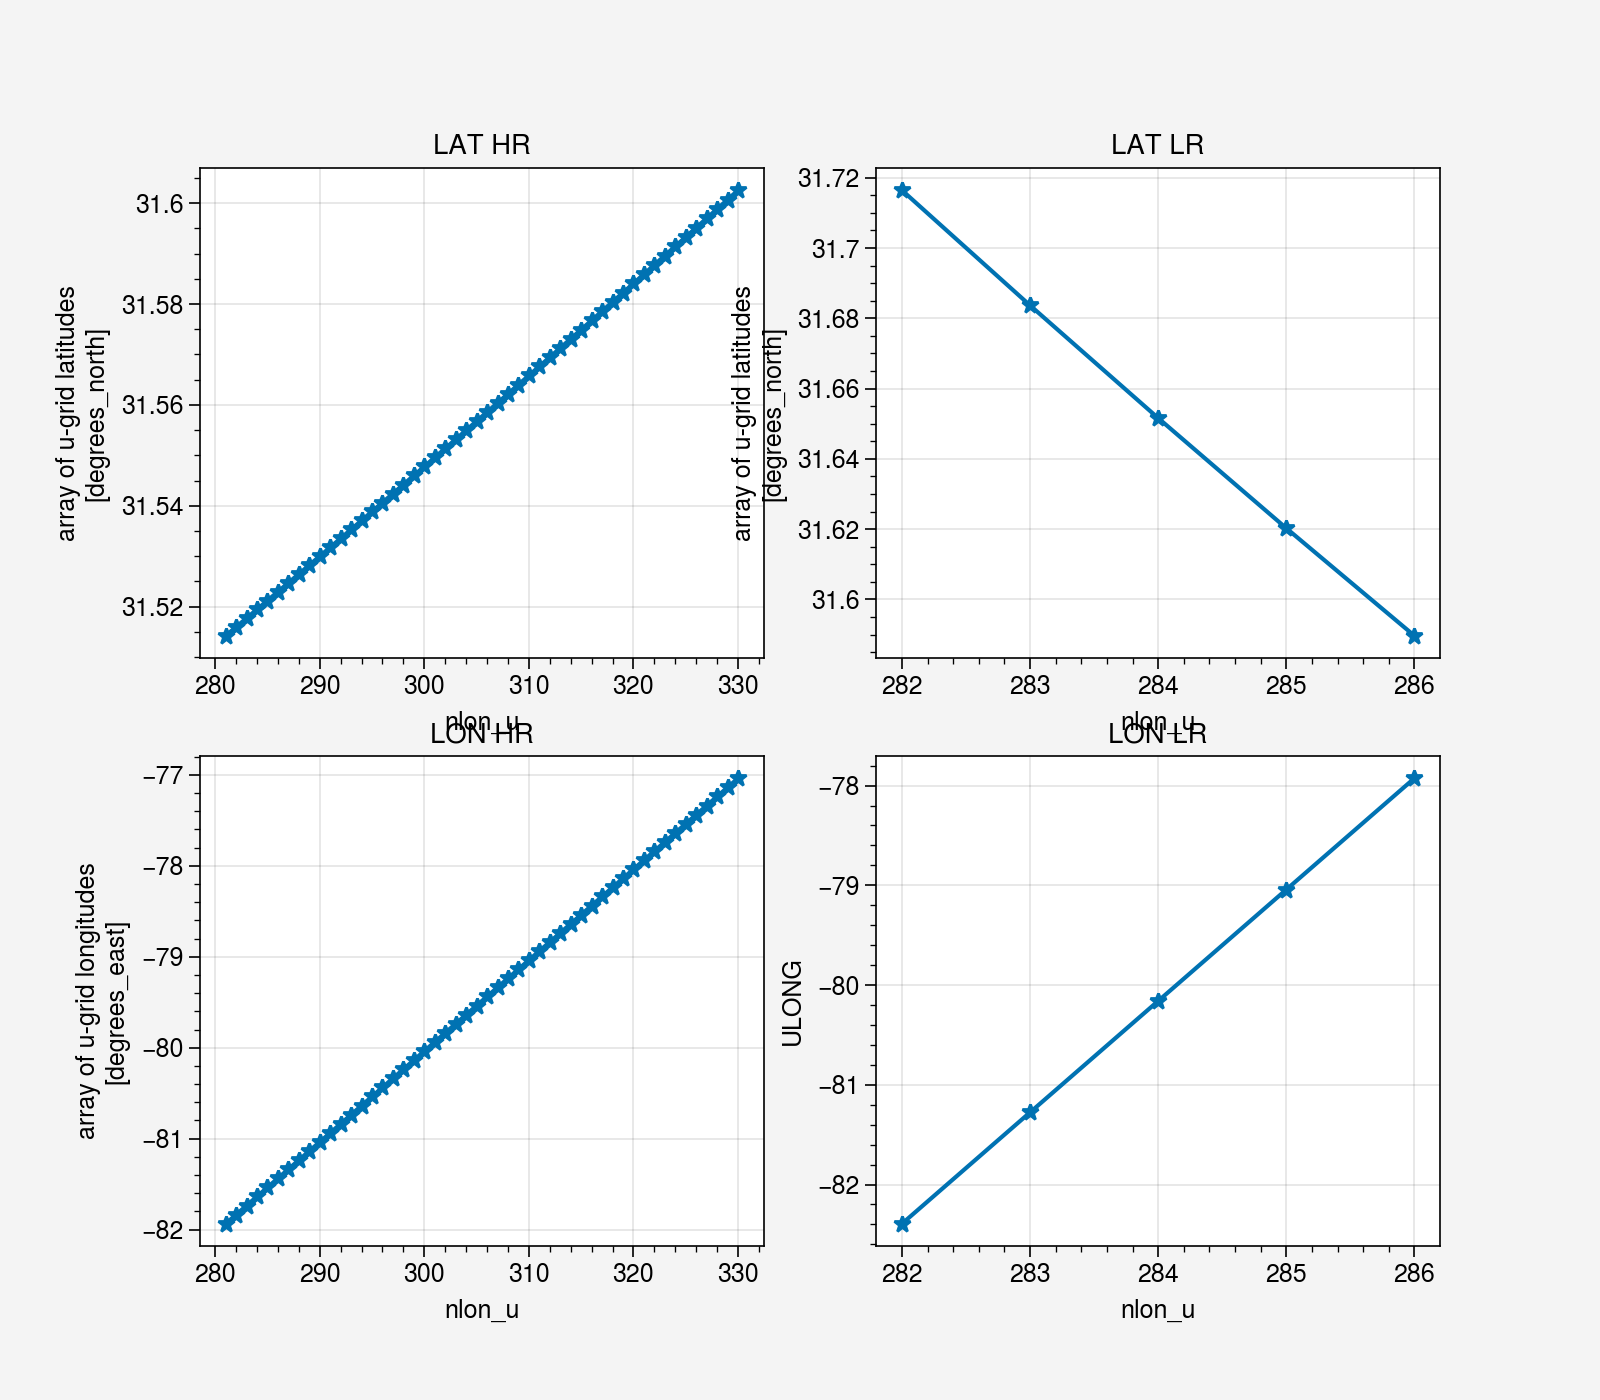

In [26]:
ilat1_t12 = 1517
ilon1_t12, ilon2_t12 = 280, 320+10

ilat1_g16 = 281
ilon1_g16, ilon2_g16 = 281, 286

fig, axs = plt.subplots(2,2,figsize=(8,7))
xds_uvel_TH.ULAT.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12)).plot(ax=axs[0,0], marker='*')
axs[0,0].set_title('LAT HR')
# print('mean lat (t12):',ds_vvel_TH.ULAT.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).mean().values)

xds_uvel_TL.ULAT.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16)).plot(ax=axs[0,1], marker='*')
axs[0,1].set_title('LAT LR')
# print('mean lat (g16):',ds0_TL.ULAT.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16)).mean().values)

xds_uvel_TH.ULONG.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12)).plot(ax=axs[1,0], marker='*')
axs[1,0].set_title('LON HR')
# print('mean lon (t12):',ds_vvel_TH.ULONG.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).mean().values)

(xds_uvel_TL.ULONG.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16))-360).plot(ax=axs[1,1], marker='*')
axs[1,1].set_title('LON LR')
# print('mean lon (g16):', ds0_TL.ULONG.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16)).mean().values-360)

[           nan            nan            nan            nan
            nan            nan            nan            nan
 7.62415879e-05 7.62454130e-05 7.62492440e-05 7.62530809e-05
 7.62569236e-05 7.62607721e-05 7.62646262e-05 7.62684860e-05
 7.62723514e-05 7.62762223e-05 7.62800987e-05 7.62839804e-05
 7.62878676e-05 7.62917600e-05 7.62956576e-05 7.62995604e-05
 7.63034683e-05 7.63073813e-05 7.63112993e-05 7.63152223e-05
 7.63191501e-05 7.63230827e-05 7.63270201e-05 7.63309623e-05
 7.63349091e-05 7.63388605e-05 7.63428164e-05 7.63467768e-05
 7.63507417e-05 7.63547109e-05 7.63586844e-05 7.63626622e-05
 7.63666442e-05 7.63706304e-05 7.63746206e-05 7.63786148e-05
 7.63826131e-05 7.63866152e-05 7.63906212e-05 7.63946310e-05
 7.63986446e-05 7.64026618e-05]
CPU times: user 1.11 s, sys: 34.8 ms, total: 1.15 s
Wall time: 10.6 s


<xarray.DataArray (time: 1200, nlon_u: 50)>
dask.array<mul, shape=(1200, 50), dtype=float64, chunksize=(120, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
    nlat_u   int64 1518
  * nlon_u   (nlon_u) int64 281 282 283 284 285 286 ... 325 326 327 328 329 330
    ULAT     (nlon_u) float64 31.51 31.52 31.52 31.52 ... 31.6 31.6 31.6 31.6
    ULONG    (nlon_u) float64 -81.93 -81.84 -81.74 ... -77.24 -77.14 -77.04

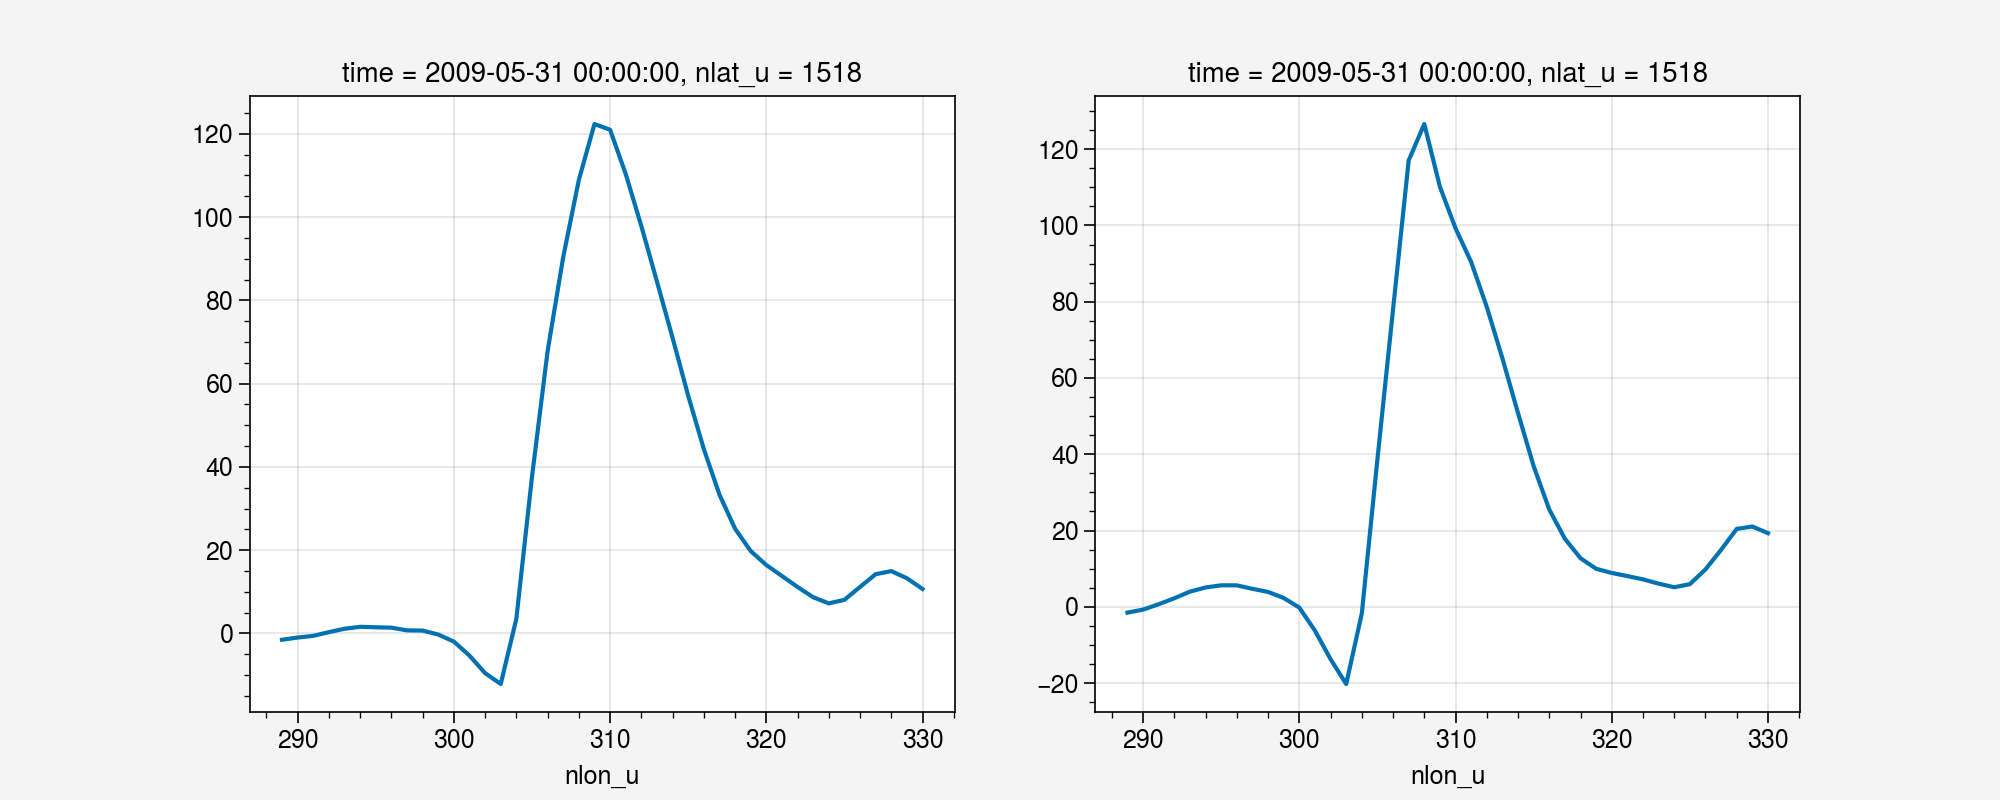

In [27]:
%%time
# compute gradient and geostrohpic vel
dsshdx_TH, dsshdy_TH = x_gradh(xds_ssh_TH.SSH, grid_ssh_TH)  # xgcm metrics version
dsshdx_TH

kmu_sec1_TH = xds_uvel_TH.KMU.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12))


ulat_sec1_TH = xds_ssh_TH.ULAT.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12))
ulatm_sec1_TH = ulat_sec1_TH.where(kmu_sec1_TH>0, np.nan) # mask land, ulat is -1 on land
f_sec1_TH = 2*omega*xr.ufuncs.sin(ulatm_sec1_TH/180*np.pi)
print(f_sec1_TH.values)

Vg_sec1_TH = dsshdx_TH.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12))*g/f_sec1_TH*100 # cm/s
Vg_sec1_TH = Vg_sec1_TH.persist()
Ug_sec1_TH = -dsshdy_TH.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12))*g/f_sec1_TH*100 # cm/s
Ug_sec1_TH = Ug_sec1_TH.persist()

dsshdx_CH, dsshdy_CH = x_gradh(xds_ssh_CH.SSH, grid_ssh_CH)  # xgcm metrics version
dsshdx_CH

Vg_sec1_CH = dsshdx_CH.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12))*g/f_sec1_TH*100 # cm/s
Vg_sec1_CH = Vg_sec1_CH.persist()
Ug_sec1_CH = -dsshdy_CH.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12))*g/f_sec1_TH*100 # cm/s
Ug_sec1_CH = Ug_sec1_CH.persist()

fig, axs = plt.subplots(1,2,figsize=(10,4))
Ug_sec1_TH.isel(time=100).plot(ax=axs[0])
Vg_sec1_TH.isel(time=100).plot(ax=axs[1])
Vg_sec1_TH

[           nan            nan 7.65089870e-05 7.64411045e-05
 7.63747962e-05]
CPU times: user 1.12 s, sys: 14.7 ms, total: 1.14 s
Wall time: 3.57 s


<xarray.DataArray (time: 1199, nlon_u: 5)>
dask.array<mul, shape=(1199, 5), dtype=float64, chunksize=(12, 5), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
    nlat_u   int64 282
  * nlon_u   (nlon_u) int64 282 283 284 285 286
    ULONG    (nlon_u) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    ULAT     (nlon_u) float64 dask.array<chunksize=(5,), meta=np.ndarray>

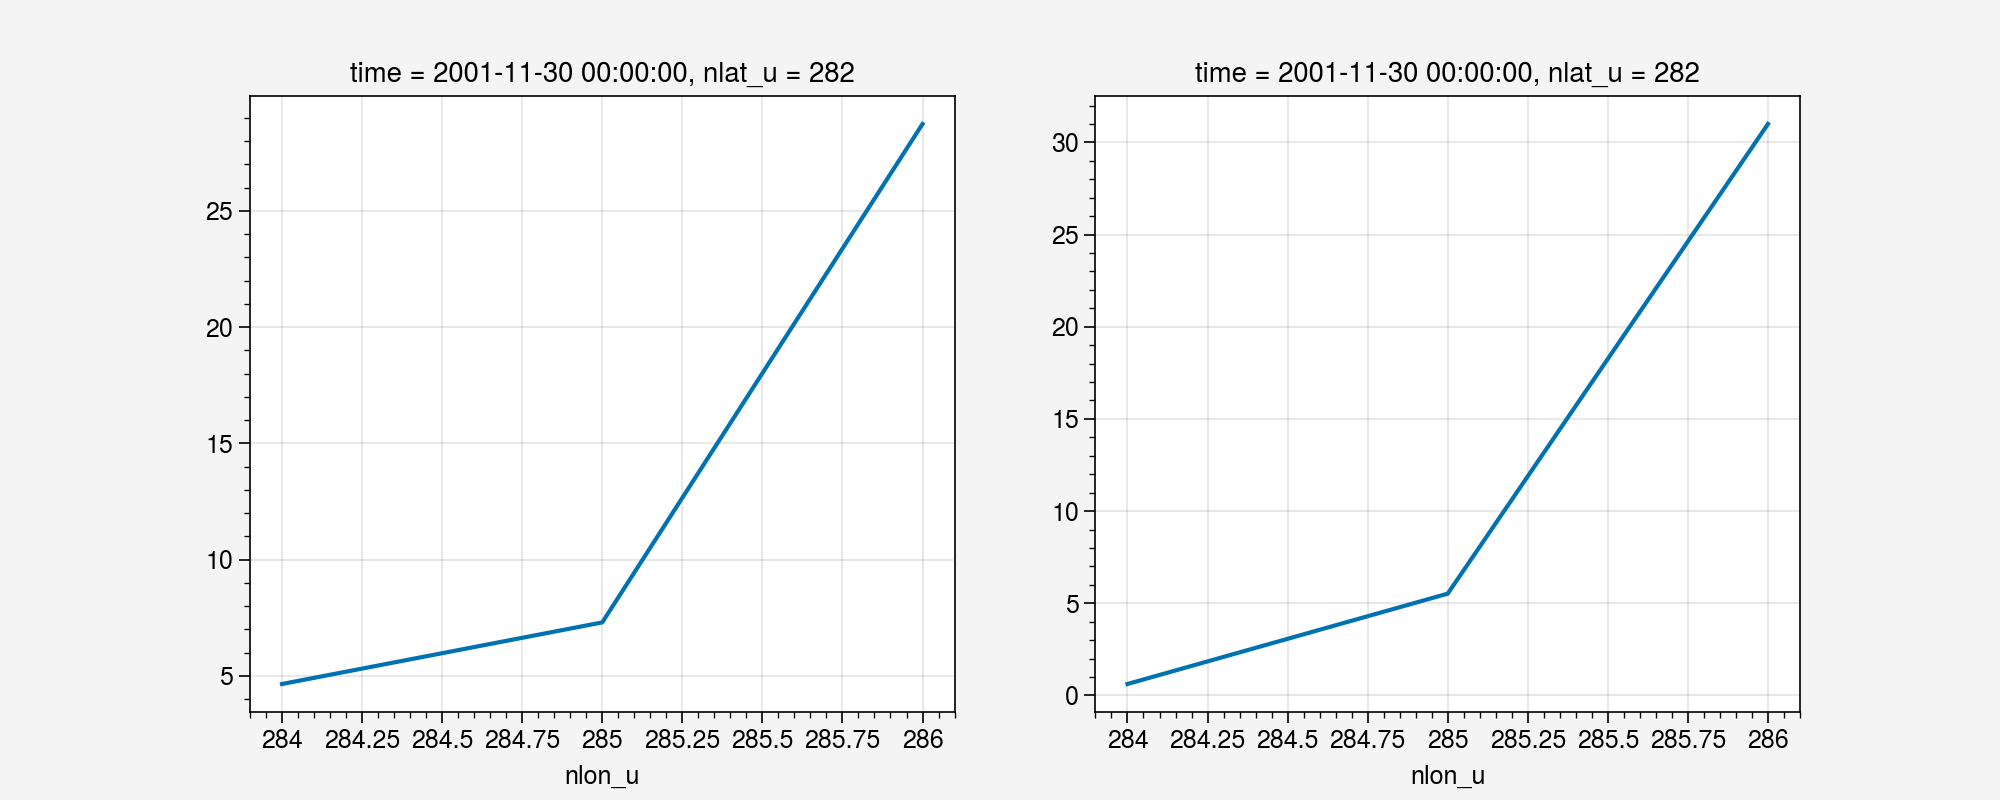

In [28]:
%%time
# compute gradient and geostrohpic vel 
dsshdx_TL, dsshdy_TL = x_gradh(xds_ssh_TL.SSH, grid_ssh_TL)  # xgcm metrics version
dsshdx_TL

kmu_sec1_TL = xds_uvel_TL.KMU.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16))

ulat_sec1_TL = xds_ssh_TL.ULAT.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16))
ulatm_sec1_TL = ulat_sec1_TL.where(kmu_sec1_TL>0, np.nan) # mask for land
f_sec1_TL = 2*omega*xr.ufuncs.sin(ulatm_sec1_TL/180*np.pi)
print(f_sec1_TL.values)

Vg_sec1_TL = dsshdx_TL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16))*g/f_sec1_TL*100 # cm/s
Vg_sec1_TL = Vg_sec1_TL.persist()
Ug_sec1_TL = -dsshdy_TL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16))*g/f_sec1_TL*100 # cm/s
Ug_sec1_TL = Ug_sec1_TL.persist()

# compute gradient and geostrohpic vel 
dsshdx_CL, dsshdy_CL = x_gradh(xds_ssh_CL.SSH, grid_ssh_CL)  # xgcm metrics version
dsshdx_CL

Vg_sec1_CL = dsshdx_CL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16))*g/f_sec1_TL*100 # cm/s
Vg_sec1_CL = Vg_sec1_CL.persist()
Ug_sec1_CL = -dsshdy_CL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16))*g/f_sec1_TL*100 # cm/s
Ug_sec1_CL = Ug_sec1_CL.persist()

fig, axs = plt.subplots(1,2,figsize=(10,4))
Ug_sec1_TL.isel(time=10).plot(ax=axs[0])
Vg_sec1_TL.isel(time=10).plot(ax=axs[1])
Vg_sec1_TL

<xarray.DataArray (time: 1200, z_t: 62, nlon_u: 50)>
dask.array<sub, shape=(1200, 62, 50), dtype=float64, chunksize=(12, 62, 30), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlon_u) float64 -81.93 -81.84 -81.74 ... -77.24 -77.14 -77.04
    ULAT     (nlon_u) float64 31.51 31.52 31.52 31.52 ... 31.6 31.6 31.6 31.6
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * nlon_u   (nlon_u) int64 281 282 283 284 285 286 ... 325 326 327 328 329 330
    nlat_u   int64 1518

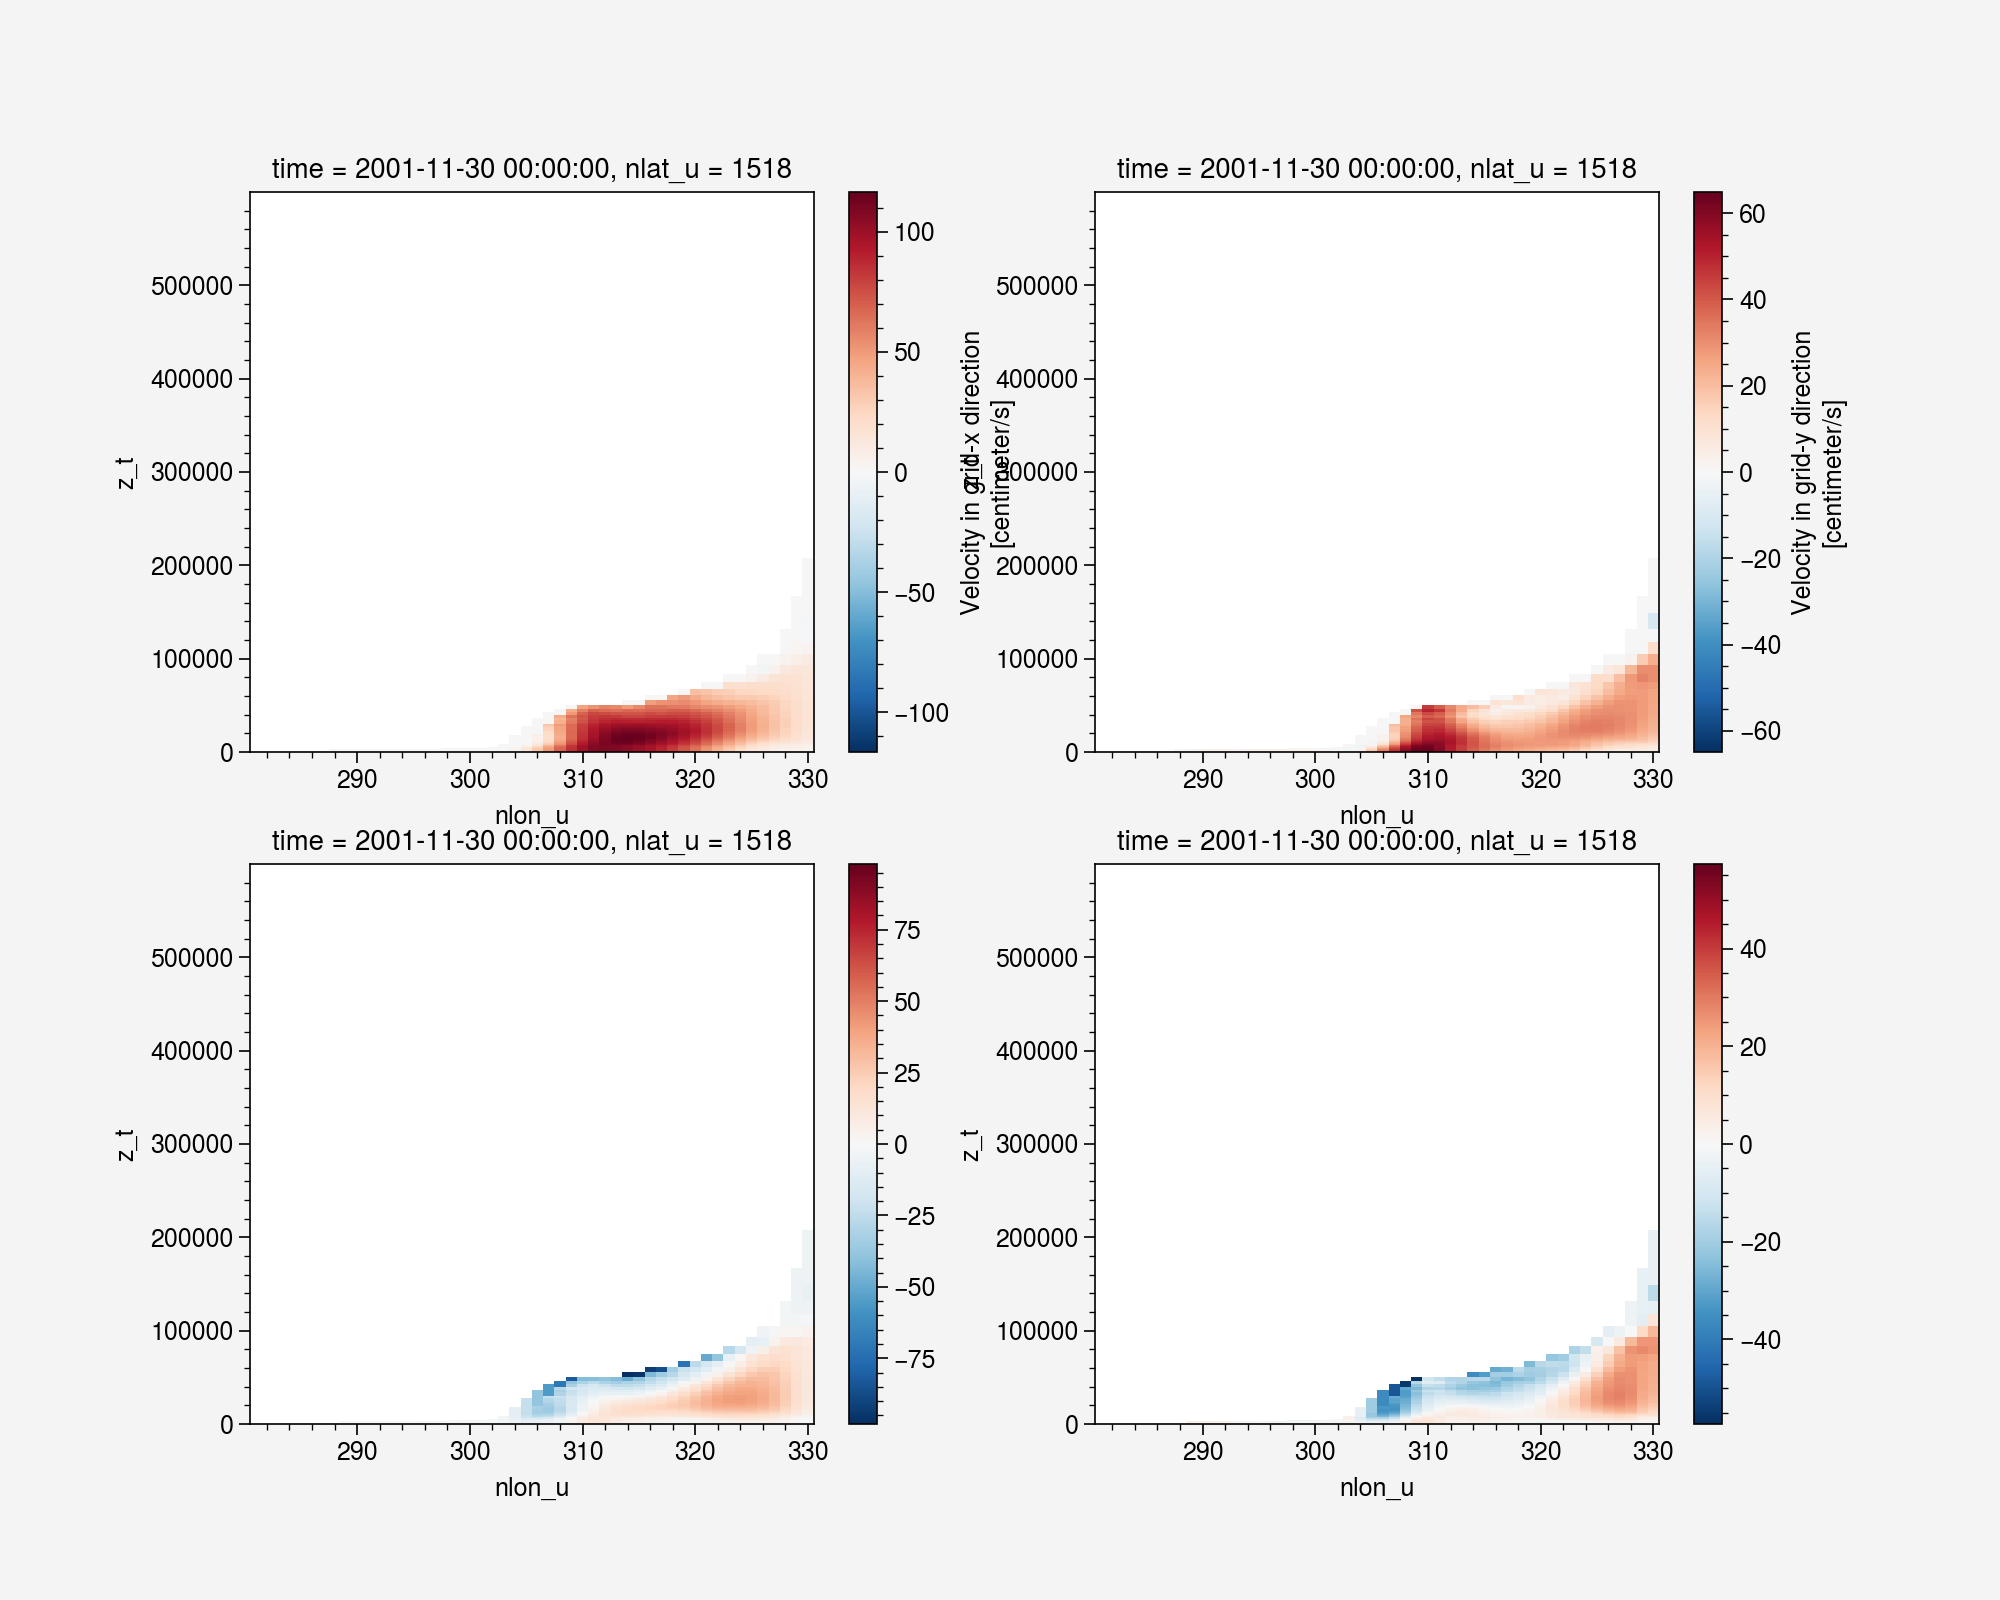

In [29]:
# compuate ageostrophic vel TH 
vvel_sec1_TH = xds_uvel_TH.VVEL.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12)) # cm/s
vvel_sec1_TH = vvel_sec1_TH.persist()
uvel_sec1_TH = xds_uvel_TH.UVEL.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12)) # cm/s
uvel_sec1_TH = uvel_sec1_TH.persist()

# uvel_sec1_TH = uvel_sec1_TH.assign_coords(time=time_vvel_s_TH)
# vvel_sec1_TH = vvel_sec1_TH.assign_coords(time=time_vvel_s_TH)
# uvel_sec1_TH.time.values, Ug_sec1_TH.time.values

Uag_sec1_TH = uvel_sec1_TH - Ug_sec1_TH
Vag_sec1_TH = vvel_sec1_TH - Vg_sec1_TH

# compuate ageostrophic vel CH 
vvel_sec1_CH = xds_uvel_CH.VVEL.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12)) # cm/s
vvel_sec1_CH = vvel_sec1_CH.persist()
uvel_sec1_CH = xds_uvel_CH.UVEL.isel(nlat_u=ilat1_t12,nlon_u=slice(ilon1_t12,ilon2_t12)) # cm/s
uvel_sec1_CH = uvel_sec1_CH.persist()

Uag_sec1_CH = uvel_sec1_CH - Ug_sec1_CH
Vag_sec1_CH = vvel_sec1_CH - Vg_sec1_CH

fig, axs = plt.subplots(2,2,figsize=(10,8))
uvel_sec1_TH.isel(time=10).plot(ax=axs[0,0])
vvel_sec1_TH.isel(time=10).plot(ax=axs[0,1])
Uag_sec1_TH.isel(time=10).plot(ax=axs[1,0])
Vag_sec1_TH.isel(time=10).plot(ax=axs[1,1])
Uag_sec1_TH

<xarray.DataArray (time: 1199, z_t: 60, nlon_u: 5)>
dask.array<sub, shape=(1199, 60, 5), dtype=float64, chunksize=(12, 60, 5), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlon_u) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    ULAT     (nlon_u) float64 dask.array<chunksize=(5,), meta=np.ndarray>
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * nlon_u   (nlon_u) int64 282 283 284 285 286
    nlat_u   int64 282

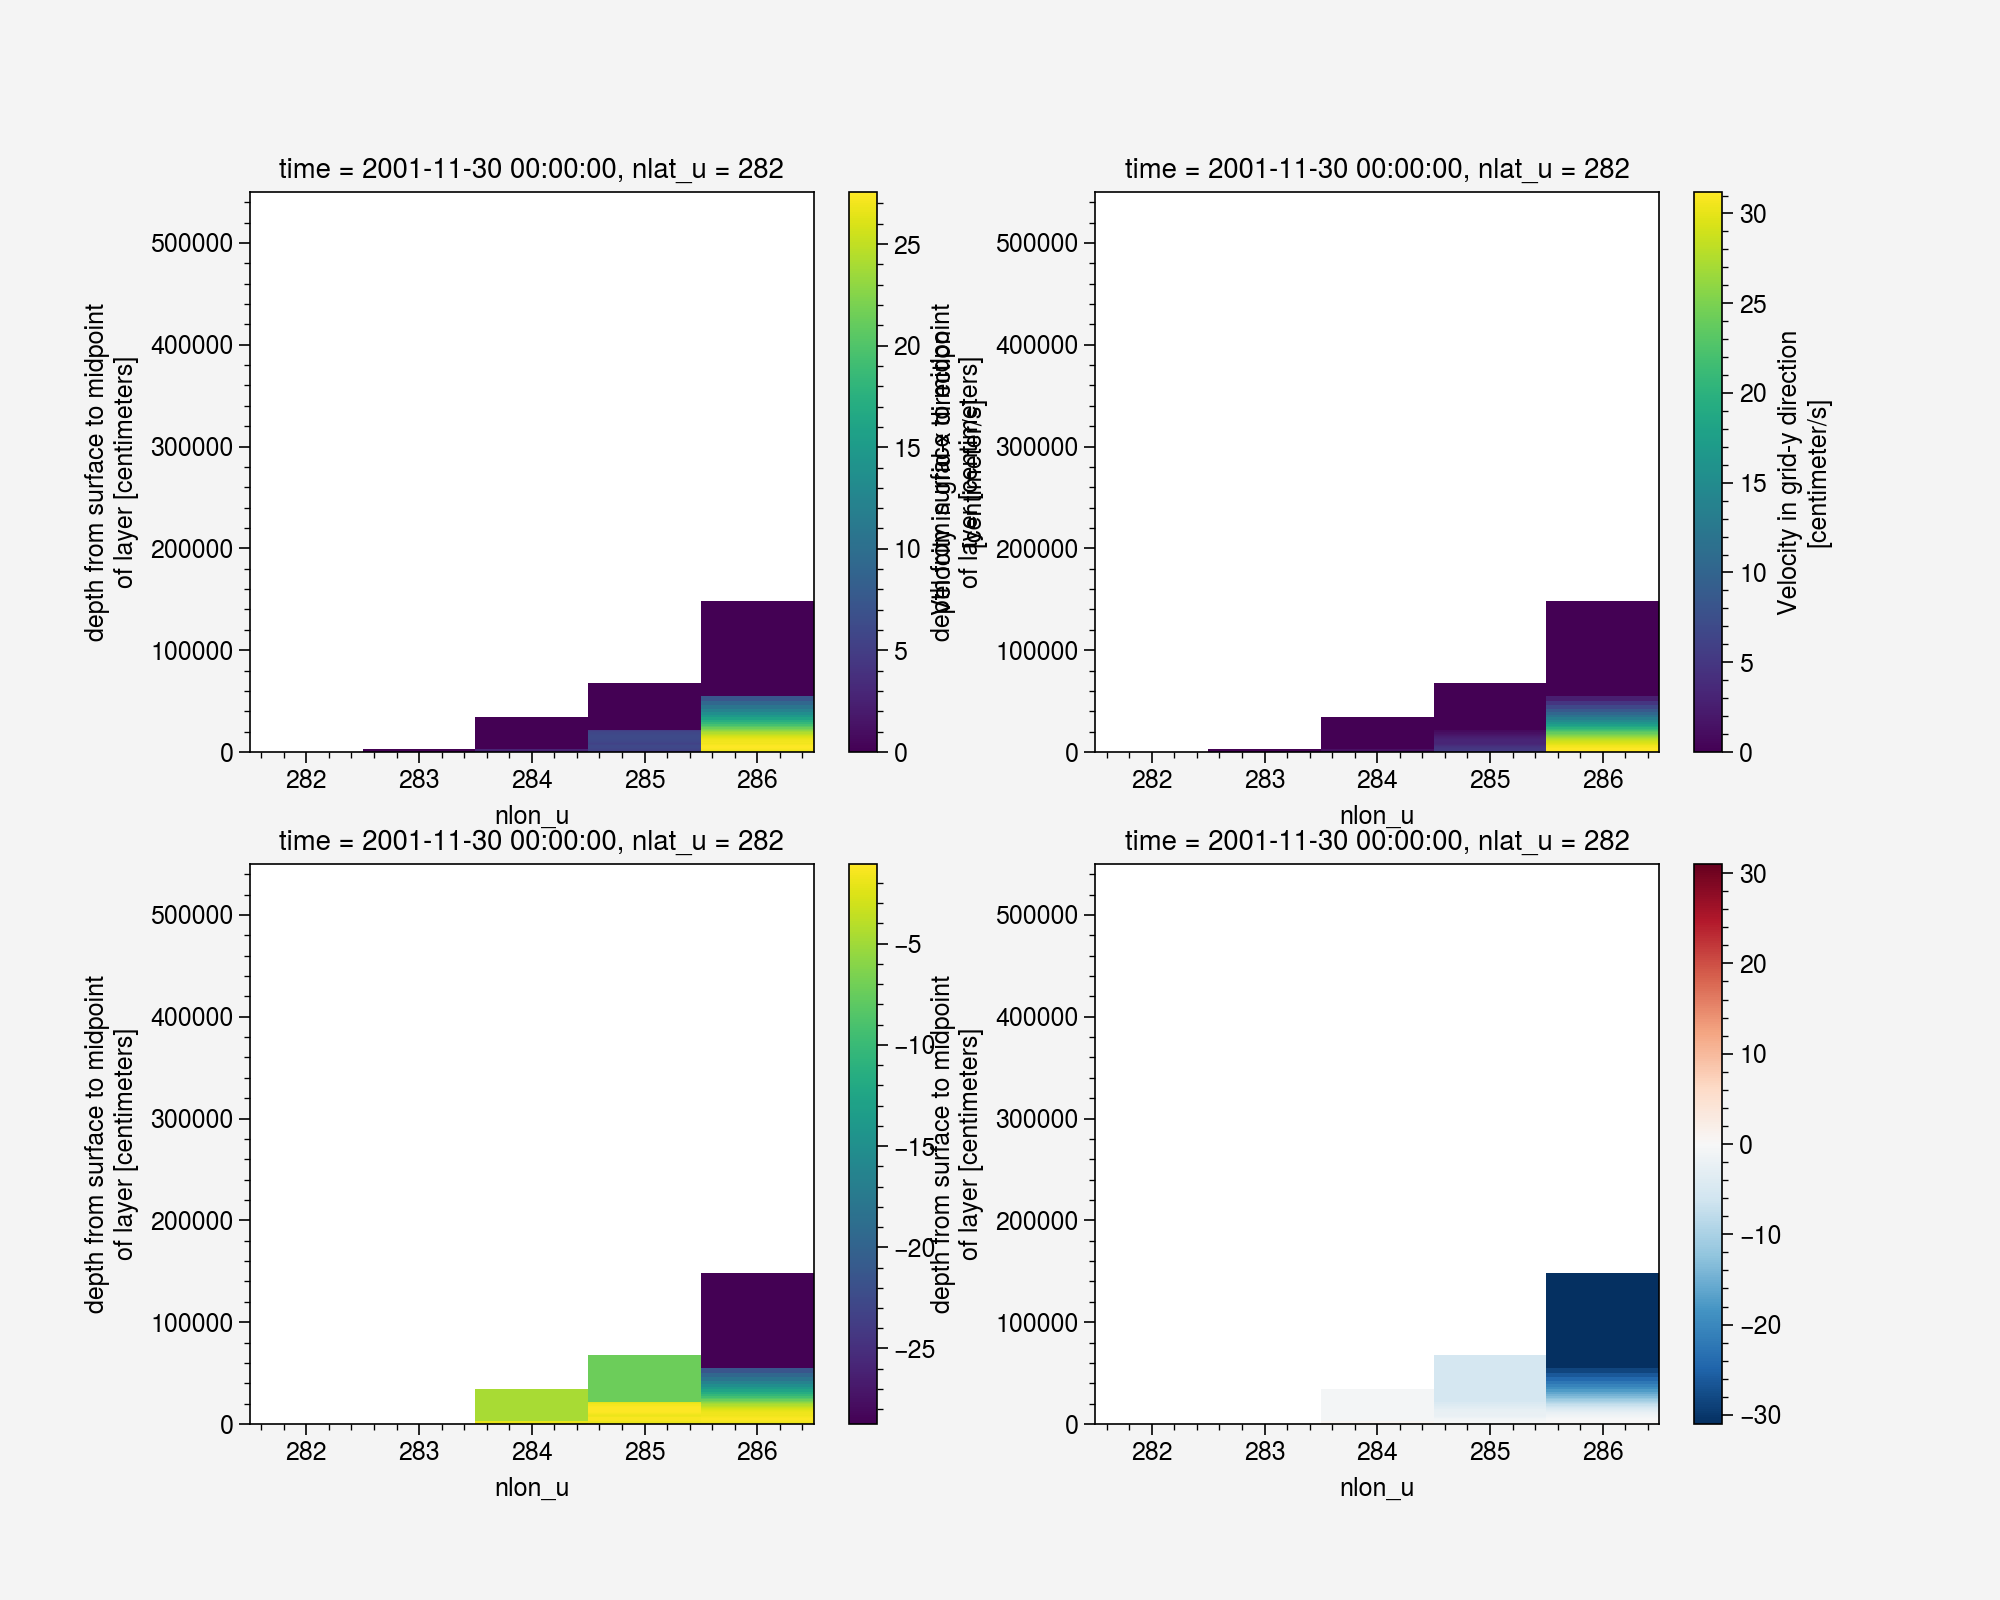

In [30]:
# compuate ageostrophic vel TL 
vvel_sec1_TL = xds_uvel_TL.VVEL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16)) # cm/s
vvel_sec1_TL = vvel_sec1_TL.persist()
uvel_sec1_TL = xds_uvel_TL.UVEL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16)) # cm/s
uvel_sec1_TL = uvel_sec1_TL.persist()

Uag_sec1_TL = uvel_sec1_TL - Ug_sec1_TL
Vag_sec1_TL = vvel_sec1_TL - Vg_sec1_TL

# compuate ageostrophic vel CL 
vvel_sec1_CL = xds_uvel_CL.VVEL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16)) # cm/s
vvel_sec1_CL = vvel_sec1_CL.persist()
uvel_sec1_CL = xds_uvel_CL.UVEL.isel(nlat_u=ilat1_g16,nlon_u=slice(ilon1_g16,ilon2_g16)) # cm/s
uvel_sec1_CL = uvel_sec1_CL.persist()

Uag_sec1_CL = uvel_sec1_CL - Ug_sec1_CL
Vag_sec1_CL = vvel_sec1_CL - Vg_sec1_CL

fig, axs = plt.subplots(2,2,figsize=(10,8))
uvel_sec1_TL.isel(time=10).plot(ax=axs[0,0])
vvel_sec1_TL.isel(time=10).plot(ax=axs[0,1])
Uag_sec1_TL.isel(time=10).plot(ax=axs[1,0])
Vag_sec1_TL.isel(time=10).plot(ax=axs[1,1])
Uag_sec1_TL

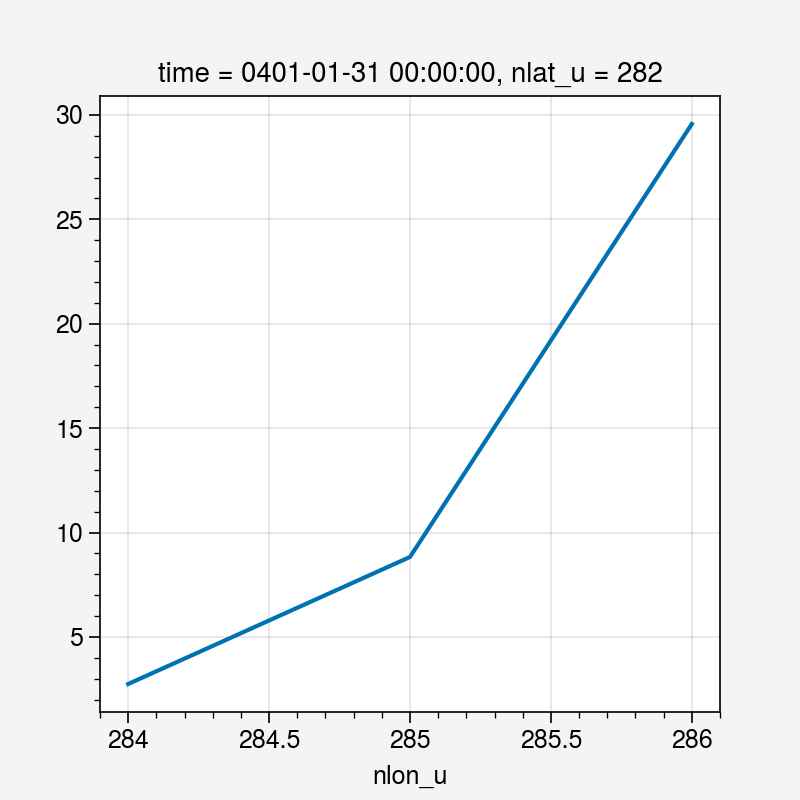

In [32]:
# Vag_sec1_CL.isel(time=0).plot()
Vg_sec1_CL.isel(time=0).plot()

In [33]:
spd2_Vag_sec1_TH = Uag_sec1_TH**2 + Vag_sec1_TH**2
spd2_Vag_sec1_CH = Uag_sec1_CH**2 + Vag_sec1_CH**2
spd2_Vag_sec1_TL = Uag_sec1_TL**2 + Vag_sec1_TL**2
spd2_Vag_sec1_CL = Uag_sec1_CL**2 + Vag_sec1_CL**2
spd2_Vag_sec1_tre_TH = spd2_Vag_sec1_TH.resample(time='A').mean('time')
spd2_Vag_sec1_tre_TL = spd2_Vag_sec1_TL.resample(time='A').mean('time')
spd2_Vag_sec1_tre_CH = spd2_Vag_sec1_CH.resample(time='A').mean('time')
spd2_Vag_sec1_tre_CL = spd2_Vag_sec1_CL.resample(time='A').mean('time')
spd2_Vag_sec1_tre_THmCH = (spd2_Vag_sec1_tre_TH - spd2_Vag_sec1_tre_CH.values).compute()
spd2_Vag_sec1_tre_TLmCL = (spd2_Vag_sec1_tre_TL - spd2_Vag_sec1_tre_CL.values).compute()
spd2_Vag_sec1_tre_THmCH

<xarray.DataArray (time: 100, z_t: 62, nlon_u: 50)>
array([[[         nan,          nan,          nan, ...,   3.50057845,
           4.39508348,   4.67158147],
        [         nan,          nan,          nan, ...,   4.61339487,
           3.70511626,   2.49138334],
        [         nan,          nan,          nan, ...,  10.21965245,
           6.96466969,   3.70184917],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,  -0.92494111,
           0.21641059,   1.03499421],
        [         nan,          nan,          nan, ...,   1.13360113,
           1.96330639,   2.57189803],
        [         nan,          nan,          nan, ...,   3.71600183,
           6.87488079,   5.76707693],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,  -1.46849526,
          16.43316325,  30.01137096],
        [         nan,          nan,          nan, ...,  -6.47996781,
           9.18865489,  22.69555625],
        [         nan,          nan,          nan, ...,  -7.10189057,
          13.23945908,  30.43815795],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time     (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlon_u) float64 -81.93 -81.84 -81.74 ... -77.24 -77.14 -77.04
    ULAT     (nlon_u) float64 31.51 31.52 31.52 31.52 ... 31.6 31.6 31.6 31.6
  * nlon_u   (nlon_u) int64 281 282 283 284 285 286 ... 325 326 327 328 329 330
    nlat_u   int64 1518

In [34]:
amoc_lat1z1_tre_TL = ds_MOC_TL.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('2001','2100'))
amoc_lat1z1_tre_TH = ds_MOC_TH.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('2001','2100'))
amoc_lat1z1_tre_CL = ds_MOC_CL.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('0401','0500'))
amoc_lat1z1_tre_CH = ds_MOC_CH.MOC.sel(moc_comp=0, transport_reg=1).sel(lat_aux_grid=26.5, moc_z=1000*100, 
                                       method='nearest').resample(time='A').mean('time').sel(time=slice('0401','0500'))

amoc_lat1z1_tre_TLmCL = amoc_lat1z1_tre_TL.values - amoc_lat1z1_tre_CL.values
amoc_lat1z1_tre_THmCH = amoc_lat1z1_tre_TH.values - amoc_lat1z1_tre_CH.values
print(amoc_lat1z1_tre_THmCH.shape)
amoc_lat1z1_tre_TH

(100,)


<xarray.DataArray 'MOC' (time: 100)>
array([18.993109 , 19.79521  , 18.396832 , 17.797712 , 17.803534 ,
       18.743433 , 17.788658 , 18.54837  , 17.697607 , 17.955914 ,
       18.75799  , 18.254066 , 18.149424 , 16.921278 , 17.949974 ,
       17.404016 , 16.25765  , 16.292301 , 16.631704 , 17.966774 ,
       16.252924 , 15.9505415, 16.007093 , 16.256676 , 16.049006 ,
       15.99453  , 16.665379 , 16.504208 , 14.7580595, 15.864484 ,
       15.045936 , 17.172813 , 17.20128  , 16.99512  , 14.857127 ,
       15.677036 , 14.910165 , 15.291038 , 15.168681 , 13.865849 ,
       14.351108 , 14.544819 , 13.792683 , 13.594245 , 13.106509 ,
       16.975685 , 14.618491 , 14.1678705, 14.481078 , 13.661316 ,
       12.789375 , 13.118271 , 15.277013 , 14.26365  , 14.008395 ,
       13.636107 , 14.192761 , 14.0836115, 12.454024 , 13.854832 ,
       13.563558 , 12.540845 , 12.353169 , 11.01447  , 11.80166  ,
       13.0009   , 13.919639 , 11.947635 , 12.976584 , 13.711999 ,
       12.127587 , 10.800492 , 11.875554 , 12.326407 , 12.055272 ,
       10.715692 , 12.650674 , 13.343089 , 11.447643 , 11.247951 ,
       10.898362 , 13.194604 , 11.17991  , 10.849677 , 11.613545 ,
       11.355656 , 11.371335 , 10.619622 ,  9.022295 , 11.909206 ,
       10.577344 , 10.468748 , 10.486183 , 10.85587  ,  9.578611 ,
       10.750318 ,  8.941472 ,  8.753316 , 10.943195 , 10.414016 ],
      dtype=float32)
Coordinates:
  * time               (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
    moc_z              float32 1.041e+05
    lat_aux_grid       float32 26.27

In [35]:
%%time 
print('spd_sec1_z1_tre_THmCH.dims', spd2_Vag_sec1_tre_THmCH.dims)
_, nz_sec1_t12, nlon_sec1_t12 = spd2_Vag_sec1_tre_THmCH.shape

spd2amoc_sec1_THmCH = np.empty((nz_sec1_t12, nlon_sec1_t12))
spd2amoc_sec1_THmCH[:] = np.nan
pspd2_sec1_THmCH = np.empty((nz_sec1_t12, nlon_sec1_t12))
pspd2_sec1_THmCH[:] = np.nan


for ilon in np.arange(0,nlon_sec1_t12):
    for iz in np.arange(0,nz_sec1_t12):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2amoc_sec1_THmCH[iz,ilon], _, _, pspd2_sec1_THmCH[iz,ilon], _ = stats.linregress(
            amoc_lat1z1_tre_THmCH, spd2_Vag_sec1_tre_THmCH[:,iz,ilon])

print(spd2amoc_sec1_THmCH.shape)
print(spd2_Vag_sec1_tre_THmCH.z_t.shape)
print(spd2_Vag_sec1_tre_THmCH.z_t.values[:,np.newaxis].shape)
z_sec1_THmCH = np.tile(spd2_Vag_sec1_tre_THmCH.z_t.values[:,np.newaxis],(1,len(spd2_Vag_sec1_tre_THmCH.ULONG)))
print(z_sec1_THmCH.shape)

print(spd2_Vag_sec1_tre_THmCH.ULONG.shape)
print(spd2_Vag_sec1_tre_THmCH.ULONG.values[np.newaxis,:].shape)
lon_sec1_THmCH = np.tile(spd2_Vag_sec1_tre_THmCH.ULONG.values[np.newaxis,:],(len(spd2_Vag_sec1_tre_THmCH.z_t),1))
print(lon_sec1_THmCH.shape)

zm_sec1_THmCH = np.where(pspd2_sec1_THmCH>0.1, z_sec1_THmCH, np.nan) # m: mask
lonm_sec1_THmCH = np.where(pspd2_sec1_THmCH>0.1,lon_sec1_THmCH, np.nan) # m: mask

spd_sec1_z1_tre_THmCH.dims ('time', 'z_t', 'nlon_u')
(62, 50)
(62,)
(62, 1)
(62, 50)
(50,)
(1, 50)
(62, 50)
CPU times: user 2.75 s, sys: 21.6 ms, total: 2.77 s
Wall time: 2.75 s


In [36]:
%%time 
print('spd_sec1_z1_tre_TLmCL.dims', spd2_Vag_sec1_tre_TLmCL.dims)
_, nz_sec1_g16, nlon_sec1_g16 = spd2_Vag_sec1_tre_TLmCL.shape

spd2amoc_sec1_TLmCL = np.empty((nz_sec1_g16, nlon_sec1_g16))
spd2amoc_sec1_TLmCL[:] = np.nan
pspd2_sec1_TLmCL = np.empty((nz_sec1_g16, nlon_sec1_g16))
pspd2_sec1_TLmCL[:] = np.nan


for ilon in np.arange(0,nlon_sec1_g16):
    for iz in np.arange(0,nz_sec1_g16):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd2amoc_sec1_TLmCL[iz,ilon], _, _, pspd2_sec1_TLmCL[iz,ilon], _ = stats.linregress(
            amoc_lat1z1_tre_TLmCL, spd2_Vag_sec1_tre_TLmCL[:,iz,ilon])

print(spd2amoc_sec1_TLmCL.shape)
print(spd2_Vag_sec1_tre_TLmCL.z_t.shape)
print(spd2_Vag_sec1_tre_TLmCL.z_t.values[:,np.newaxis].shape)
z_sec1_TLmCL = np.tile(spd2_Vag_sec1_tre_TLmCL.z_t.values[:,np.newaxis],(1,len(spd2_Vag_sec1_tre_TLmCL.ULONG)))
print(z_sec1_TLmCL.shape)

print(spd2_Vag_sec1_tre_TLmCL.ULONG.shape)
print(spd2_Vag_sec1_tre_TLmCL.ULONG.values[np.newaxis,:].shape)
lon_sec1_TLmCL = np.tile(spd2_Vag_sec1_tre_TLmCL.ULONG.values[np.newaxis,:],(len(spd2_Vag_sec1_tre_TLmCL.z_t),1))
print(lon_sec1_TLmCL.shape)

zm_sec1_TLmCL = np.where(pspd2_sec1_TLmCL>0.1, z_sec1_TLmCL, np.nan) # m: mask
lonm_sec1_TLmCL = np.where(pspd2_sec1_TLmCL>0.1,lon_sec1_TLmCL, np.nan) # m: mask

spd_sec1_z1_tre_TLmCL.dims ('time', 'z_t', 'nlon_u')
(60, 5)
(60,)
(60, 1)
(60, 5)
(5,)
(1, 5)
(60, 5)
CPU times: user 273 ms, sys: 11.9 ms, total: 285 ms
Wall time: 276 ms


# make pics

In [37]:
spd2_Vag_sec1_t1av_TL = spd2_Vag_sec1_tre_TL.sel(time=slice('2001','2020')).mean('time')
spd2_Vag_sec1_t1av_TH = spd2_Vag_sec1_tre_TH.sel(time=slice('2001','2020')).mean('time')

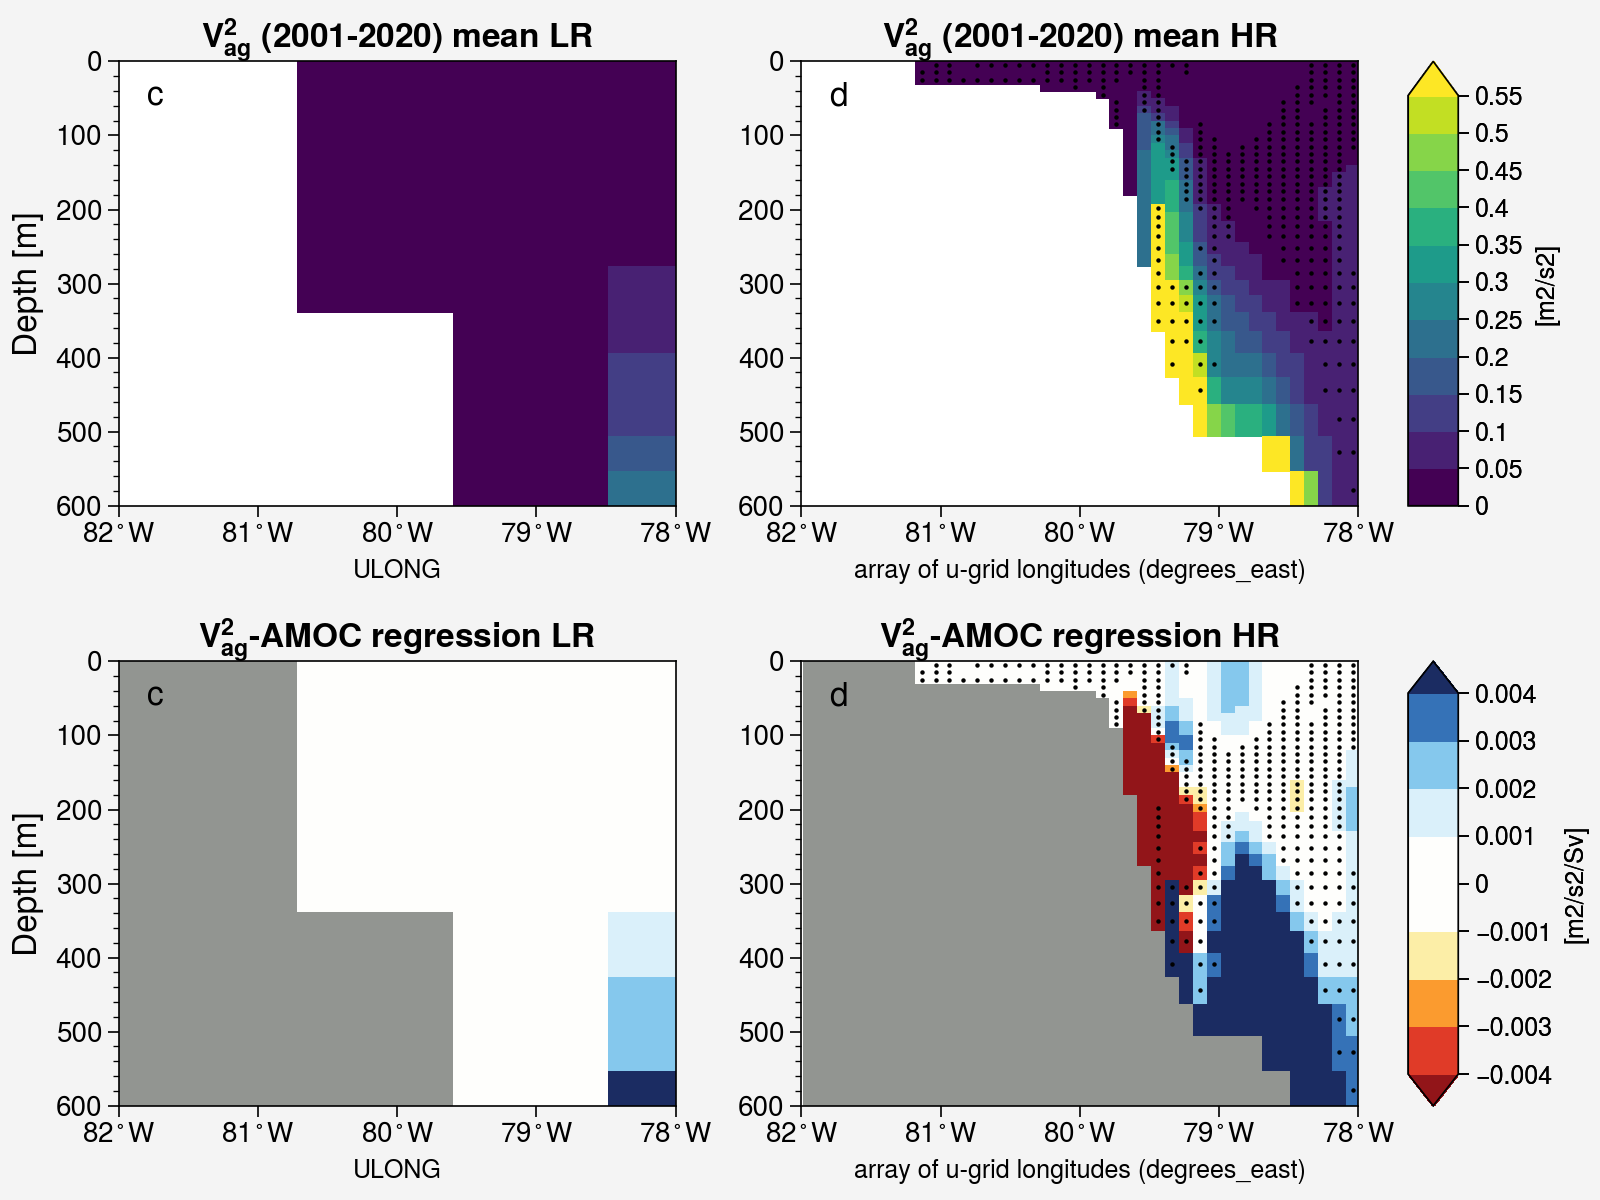

In [50]:
cmap2 = plot.Colormap('ColdHot_r',cut=-0.1) # create a colopmap with white in central(cut=-0.1) and grey for nan (lands)
cmap2.set_bad(color='grey')

xlim1_plt, xlim2_plt = -82,-78
xticks_plt = np.arange(-82,-78+0.1,1)
xtickslabel_plt = ['82$^\circ$W','81$^\circ$W','80$^\circ$W','79$^\circ$W','78$^\circ$W']
ylim1_plt, ylim2_plt = 0, 600

x4text, y4text = -81.8, 60
cut=-0.1

fig2, axs = plot.subplots(nrows=2,ncols=2, width='8in',height='6in',share=False)

m10 = axs[0,0].pcolormesh(spd2_Vag_sec1_tre_TLmCL.ULONG-360, spd2_Vag_sec1_tre_TLmCL.z_t/100, spd2_Vag_sec1_t1av_TL/1e4, 
                          cmap='viridis', levels=np.arange(0, 0.5+0.1, 0.05), extend='max')
# axs[0,0].scatter(lonm_sec1_TLmCL-360,zm_sec1_TLmCL/100, marker='o',s=1,c='k')
axs[0,0].set_xticks(xticks_plt)
axs[0,0].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[0,0].set_xlim([xlim1_plt, xlim2_plt])
axs[0,0].tick_params(axis='x', which='minor', bottom=False)
axs[0,0].set_ylim([ylim1_plt, ylim2_plt])
axs[0,0].invert_yaxis()
axs[0,0].tick_params(axis='both', which='major', labelsize=10)
axs[0,0].set_ylabel('Depth [m]', fontsize=12)
axs[0,0].set_title(r'$V_{ag}^2$ (2001-2020) mean LR', fontsize=12, fontweight='bold')
axs[0,0].text(x4text, y4text, 'c', fontsize=12)

m11 = axs[0,1].pcolormesh(spd2_Vag_sec1_tre_THmCH.ULONG, spd2_Vag_sec1_tre_THmCH.z_t/100, spd2_Vag_sec1_t1av_TH/1e4, 
                          cmap='viridis', levels=np.arange(0, 0.5+0.1, 0.05), extend='max')
axs[0,1].scatter(lonm_sec1_THmCH,zm_sec1_THmCH/100, marker='o',s=1,c='k')
axs[0,1].set_xticks(xticks_plt)
axs[0,1].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[0,1].set_xlim([xlim1_plt, xlim2_plt])
axs[0,1].tick_params(axis='x', which='minor', bottom=False)
axs[0,1].set_ylim([ylim1_plt, ylim2_plt])
axs[0,1].set_ylabel('')
axs[0,1].invert_yaxis()
axs[0,1].tick_params(axis='both', which='major', labelsize=10)
axs[0,1].set_title(r'$V_{ag}^2$ (2001-2020) mean HR', fontsize=12, fontweight='bold')
axs[0,1].text(x4text, y4text, 'd', fontsize=12)
cb = axs[0,1].colorbar(m11,loc='r',label='[m2/s2]',width='2em',shrink=1)

m10 = axs[1,0].pcolormesh(spd2_Vag_sec1_tre_TLmCL.ULONG-360, spd2_Vag_sec1_tre_TLmCL.z_t/100, spd2amoc_sec1_TLmCL/1e4, 
                          cmap=cmap2, levels=np.arange(-0.4, 0.4+0.1, 0.1)*1e-2,cmap_kw={'cut': cut}, extend='both')
# axs[0,0].scatter(lonm_sec1_TLmCL-360,zm_sec1_TLmCL/100, marker='o',s=1,c='k')
axs[1,0].set_xticks(xticks_plt)
axs[1,0].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[1,0].set_xlim([xlim1_plt, xlim2_plt])
axs[1,0].tick_params(axis='x', which='minor', bottom=False)
axs[1,0].set_ylim([ylim1_plt, ylim2_plt])
axs[1,0].invert_yaxis()
axs[1,0].tick_params(axis='both', which='major', labelsize=10)
axs[1,0].set_ylabel('Depth [m]', fontsize=12)
axs[1,0].set_title(r'$V_{ag}^2$-AMOC regression LR', fontsize=12, fontweight='bold')
axs[1,0].text(x4text, y4text, 'c', fontsize=12)

m11 = axs[1,1].pcolormesh(spd2_Vag_sec1_tre_THmCH.ULONG, spd2_Vag_sec1_tre_THmCH.z_t/100, spd2amoc_sec1_THmCH/1e4, 
                          cmap=cmap2, levels=np.arange(-0.4, 0.4+0.1, 0.1)*1e-2,cmap_kw={'cut': cut}, extend='both')
axs[1,1].scatter(lonm_sec1_THmCH,zm_sec1_THmCH/100, marker='o',s=1,c='k')
axs[1,1].set_xticks(xticks_plt)
axs[1,1].set_xticklabels(xtickslabel_plt, fontsize=12)
axs[1,1].set_xlim([xlim1_plt, xlim2_plt])
axs[1,1].tick_params(axis='x', which='minor', bottom=False)
axs[1,1].set_ylim([ylim1_plt, ylim2_plt])
axs[1,1].set_ylabel('')
axs[1,1].invert_yaxis()
axs[1,1].tick_params(axis='both', which='major', labelsize=10)
axs[1,1].set_title(r'$V_{ag}^2$-AMOC regression HR', fontsize=12, fontweight='bold')
axs[1,1].text(x4text, y4text, 'd', fontsize=12)
cb = axs[1,1].colorbar(m11,loc='r',label='[m2/s2/Sv]',width='2em',shrink=1)

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic2 = outdir + 'Vag_AMOCregressionUSsoutheastCostCrossSections4reviewer2_2022Feb07.png'

fig2.savefig(pic2,bbox_inches='tight')

# Appendix

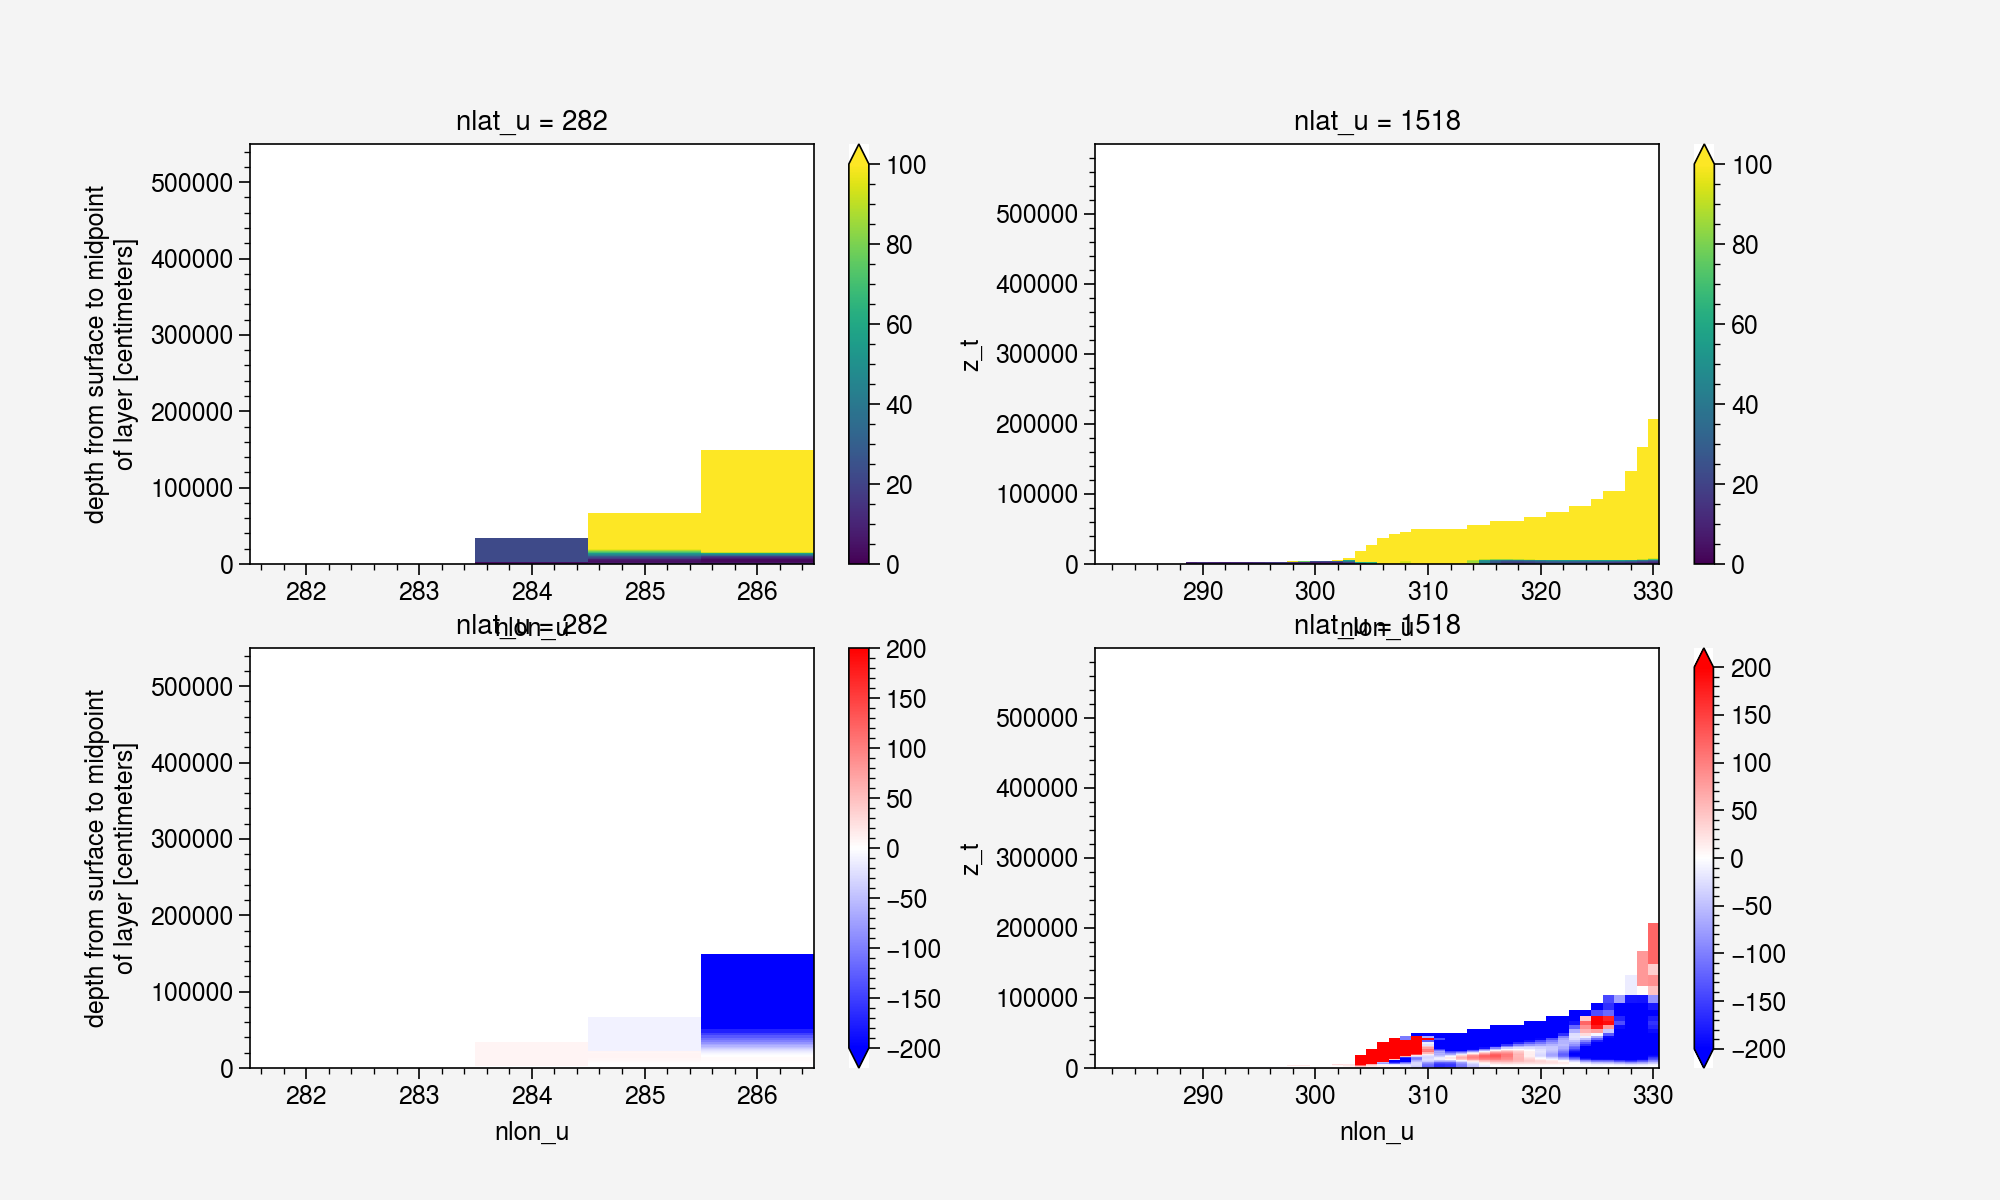

In [31]:
spd2_Vag_sec1_TH = Uag_sec1_TH**2 + Vag_sec1_TH**2
spd2_Vag_sec1_TL = Uag_sec1_TL**2 + Vag_sec1_TL**2
spd2_Vag_sec1_t1av_TH = spd2_Vag_sec1_TH.sel(time=slice('2001','2020')).mean('time') 
spd2_Vag_sec1_t2av_TH = spd2_Vag_sec1_TH.sel(time=slice('2081','2100')).mean('time') 
spd2_Vag_sec1_t1av_TL = spd2_Vag_sec1_TL.sel(time=slice('2001','2020')).mean('time') 
spd2_Vag_sec1_t2av_TL = spd2_Vag_sec1_TL.sel(time=slice('2081','2100')).mean('time') 
spd2_Vag_sec1_TH
fig, axs = plt.subplots(2,2,figsize=(10,6))
spd2_Vag_sec1_t1av_TL.plot(ax=axs[0,0], vmin=0, vmax=100)
spd2_Vag_sec1_t1av_TH.plot(ax=axs[0,1], vmin=0, vmax=100)
(spd2_Vag_sec1_t2av_TL - spd2_Vag_sec1_t1av_TL).plot(ax=axs[1,0], cmap='bwr',vmin=-200, vmax=200)
(spd2_Vag_sec1_t2av_TH - spd2_Vag_sec1_t1av_TH).plot(ax=axs[1,1], cmap='bwr',vmin=-200, vmax=200)

In [33]:
spd2_Vag_sec1_t1av_TL = spd2_Vag_sec1_t1av_TL.compute()
spd2_Vag_sec1_t1av_TH = spd2_Vag_sec1_t1av_TH.compute()
spd2_Vag_sec1_dt_TL = (spd2_Vag_sec1_t2av_TL - spd2_Vag_sec1_t1av_TL).compute()
spd2_Vag_sec1_dt_TH = (spd2_Vag_sec1_t2av_TH - spd2_Vag_sec1_t1av_TH).compute()

In [41]:
spd2_Vag_sec1_t1av_TL#.plot()

<xarray.DataArray (z_t: 60, nlon_u: 5)>
array([[           nan,            nan, 9.02084850e+00, 1.27228426e+01,
        1.15677479e+01],
       [           nan,            nan, 3.65273859e+00, 5.79249790e+00,
        5.06533871e+00],
       [           nan,            nan, 3.28372192e+00, 3.50113247e+00,
        2.52686593e+00],
       [           nan,            nan, 2.24576738e+01, 3.93865157e+00,
        2.01820180e+00],
       [           nan,            nan, 2.24576738e+01, 5.25351941e+00,
        2.24943203e+00],
       [           nan,            nan, 2.24576738e+01, 7.94966224e+00,
        3.04425380e+00],
       [           nan,            nan, 2.24576738e+01, 1.17662908e+01,
        4.80046593e+00],
       [           nan,            nan, 2.24576738e+01, 1.64496793e+01,
        7.61164208e+00],
       [           nan,            nan, 2.24576738e+01, 2.18017556e+01,
        1.17757360e+01],
       [           nan,            nan, 2.24576738e+01, 2.75514195e+01,
        1.74452287e+01],
...
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan]])
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlon_u) float64 277.6 278.7 279.8 281.0 282.1
    ULAT     (nlon_u) float64 31.72 31.68 31.65 31.62 31.59
  * nlon_u   (nlon_u) int64 282 283 284 285 286
    nlat_u   int64 282

In [48]:
# (spd2_Vag_sec1_t1av_TL.transpose).values#


array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,         

/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/ipykerne

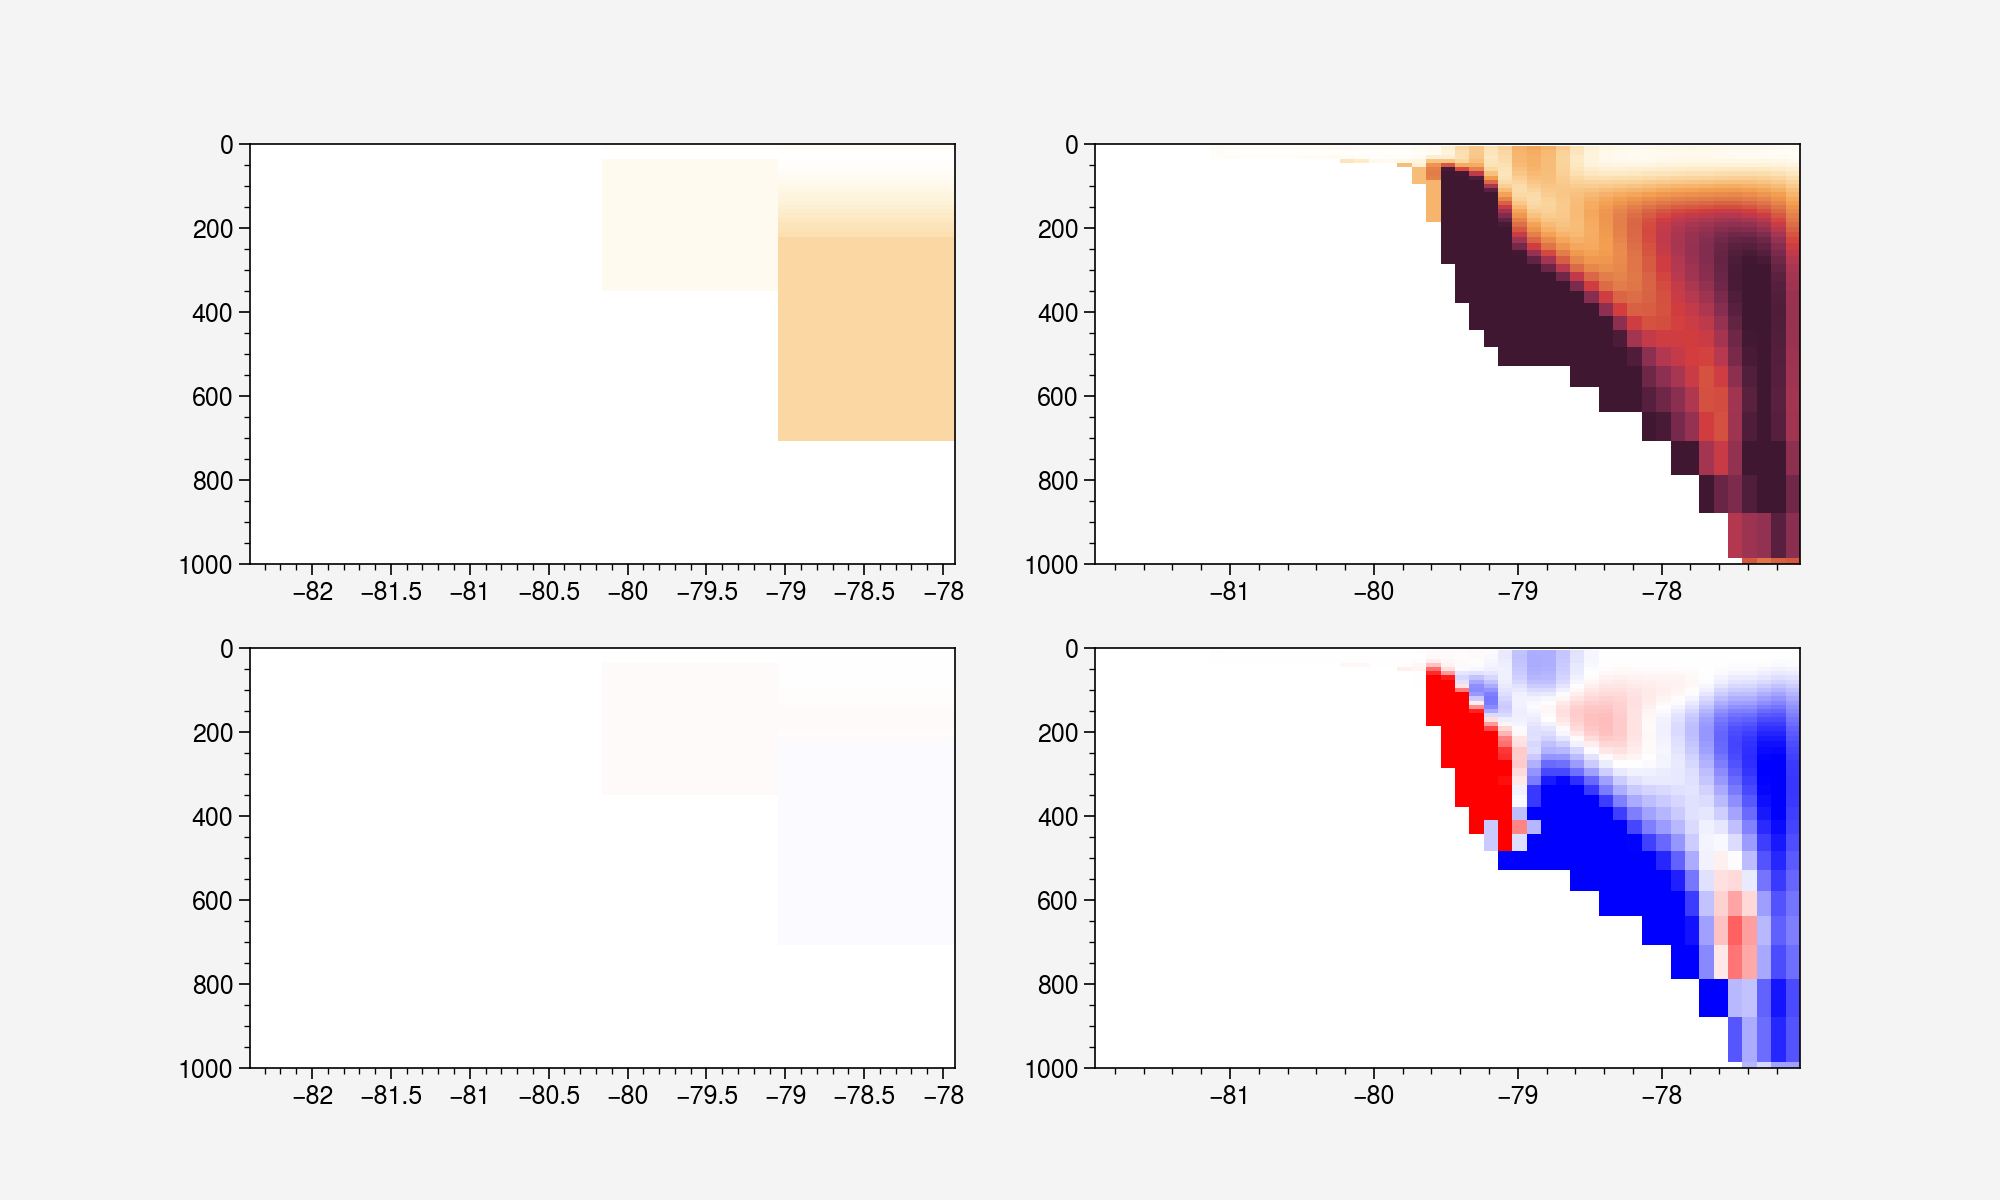

In [58]:
fig, axs = plt.subplots(2,2,figsize=(10,6))

axs[0,0].pcolormesh(spd2_Vag_sec1_t1av_TL.ULONG-360, spd2_Vag_sec1_t1av_TL.z_t/100, spd2_Vag_sec1_t1av_TL,vmin=0,vmax=1000)
axs[0,0].set_ylim([0,1000])
axs[0,0].invert_yaxis()


axs[0,1].pcolormesh(spd2_Vag_sec1_t1av_TH.ULONG, spd2_Vag_sec1_t1av_TH.z_t/100, spd2_Vag_sec1_t1av_TH,vmin=0,vmax=1000)
axs[0,1].set_ylim([0,1000])
axs[0,1].invert_yaxis()


axs[1,0].pcolormesh(spd2_Vag_sec1_t1av_TL.ULONG-360, spd2_Vag_sec1_t1av_TL.z_t/100, spd2_Vag_sec1_dt_TL,vmin=-500,vmax=500,cmap='bwr')
axs[1,0].set_ylim([0,1000])
axs[1,0].invert_yaxis()

axs[1,1].pcolormesh(spd2_Vag_sec1_t1av_TH.ULONG, spd2_Vag_sec1_t1av_TH.z_t/100, spd2_Vag_sec1_dt_TH,vmin=-500,vmax=500,cmap='bwr')
axs[1,1].set_ylim([0,1000])
axs[1,1].invert_yaxis()

# spd2_Vag_sec1_t1av_TL.sel(z_t=slice(0,1000*100)).plot(ax=axs[0,0], vmin=0, vmax=1000, yincrease=False)
# spd2_Vag_sec1_t1av_TH.sel(z_t=slice(0,1000*100)).plot(ax=axs[0,1], vmin=0, vmax=1000, yincrease=False)
# (spd2_Vag_sec1_dt_TL).sel(z_t=slice(0,1000*100)).plot(ax=axs[1,0], cmap='bwr',vmin=-200, vmax=200, yincrease=False)
# (spd2_Vag_sec1_dt_TH).sel(z_t=slice(0,1000*100)).plot(ax=axs[1,1], cmap='bwr',vmin=-200, vmax=200, yincrease=False)

<xarray.DataArray (nlat_u: 700, nlon_u: 500)>
array([[105.18863014, 102.41094713, 100.42383862, ...,   8.98153674,
          8.72236607,   8.3594907 ],
       [100.04059155,  98.0847402 ,  98.51908632, ...,   8.5428778 ,
          8.32015521,   7.7876741 ],
       [ 96.62407402,  96.93949446,  98.73582644, ...,   8.11895019,
          7.74993576,   7.11064135],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])
Coordinates:
    z_t      float32 1.05e+04
    ULONG    (nlat_u, nlon_u) float64 -89.9 -89.8 -89.7 -89.6 ... -1.0 -1.0 -1.0
    ULAT     (nlat_u, nlon_u) float64 11.82 11.82 11.82 11.82 ... -1.0 -1.0 -1.0
  * nlon_u   (nlon_u) int64 201 202 203 204 205 206 ... 695 696 697 698 699 700
  * nlat_u   (nlat_u) int64 1301 1302 1303 1304 1305 ... 1997 1998 1999 2000

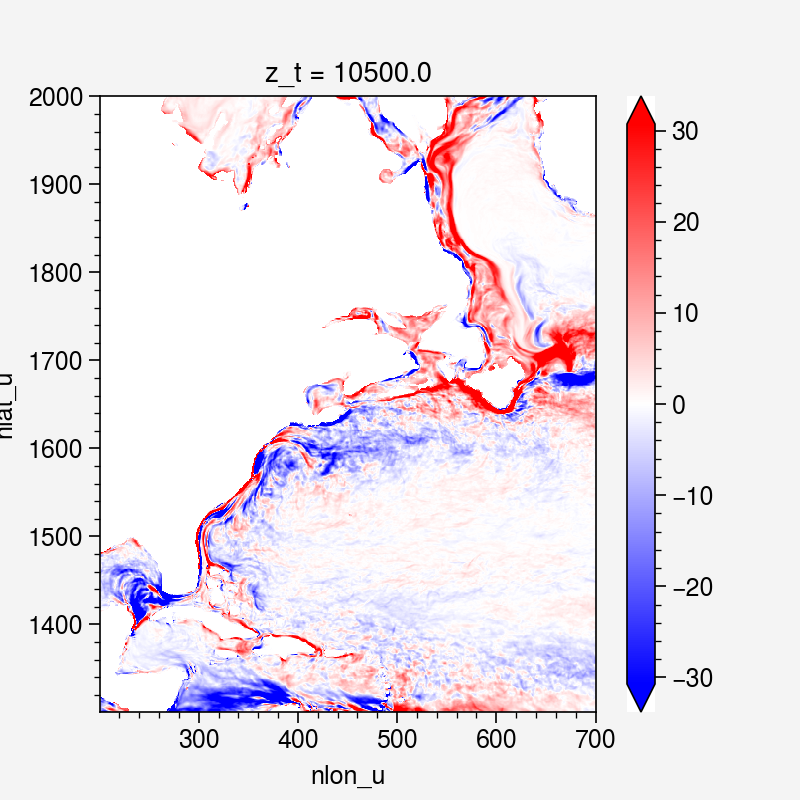

In [31]:
# # compute Vg spd HR
# spd_Vg_r_TH = xr.ufuncs.sqrt(Ug_r_TH**2 + Vg_r_TH**2)
# spd_Vg_r_CH = xr.ufuncs.sqrt(Ug_r_CH**2 + Vg_r_CH**2)

# spd_Vg_r_t1av_TH = spd_Vg_r_TH.sel(time=slice('2001','2020')).mean('time')
# spd_Vg_r_t2av_TH = spd_Vg_r_TH.sel(time=slice('2081','2100')).mean('time')

# spd_Vg_r_t1av_CH = spd_Vg_r_CH.sel(time=slice('0401','0420')).mean('time')
# spd_Vg_r_t2av_CH = spd_Vg_r_CH.sel(time=slice('0481','0500')).mean('time')

# spd_Vg_r_dt_TH = (spd_Vg_r_t2av_TH - spd_Vg_r_t1av_TH).compute()
# spd_Vg_r_dt_CH = (spd_Vg_r_t2av_CH - spd_Vg_r_t1av_CH).compute()

# spd_Vg_r_dt_THmCH = spd_Vg_r_dt_TH - spd_Vg_r_dt_CH

# compute Vag spd var TH
spd_Vag_r_TH = xr.ufuncs.sqrt(Uag_r_TH**2 + Vag_r_TH**2)
spd_Vag_r_t1var_TH = spd_Vag_r_TH.sel(time=slice('2001','2020')).var('time').compute()
spd_Vag_r_t2var_TH = spd_Vag_r_TH.sel(time=slice('2081','2100')).var('time').compute()
(spd_Vag_r_t2var_TH-spd_Vag_r_t1var_TH).plot(cmap='bwr',robust=True)
spd_Vag_r_t1var_TH

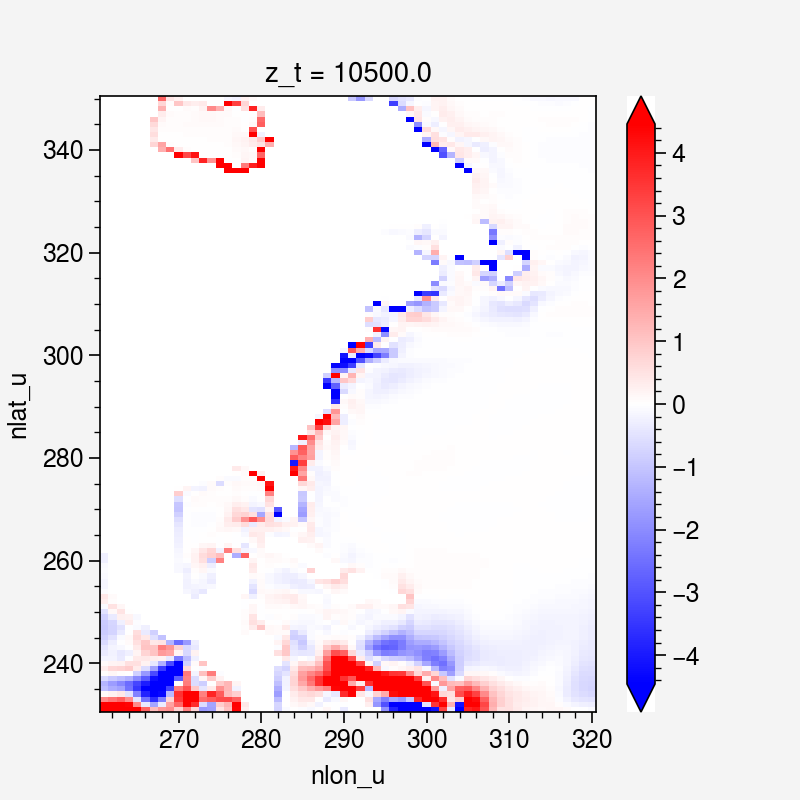

In [33]:
# compute Vg spd LR
# spd_Vg_r_TL = xr.ufuncs.sqrt(Ug_r_TL**2 + Vg_r_TL**2)
# spd_Vg_r_CL = xr.ufuncs.sqrt(Ug_r_CL**2 + Vg_r_CL**2)

# spd_Vg_r_t1av_TL = spd_Vg_r_TL.sel(time=slice('2001','2020')).mean('time')
# spd_Vg_r_t2av_TL = spd_Vg_r_TL.sel(time=slice('2081','2100')).mean('time')

# spd_Vg_r_t1av_CL = spd_Vg_r_CL.sel(time=slice('0401','0420')).mean('time')
# spd_Vg_r_t2av_CL = spd_Vg_r_CL.sel(time=slice('0481','0500')).mean('time')

# spd_Vg_r_dt_TL = (spd_Vg_r_t2av_TL - spd_Vg_r_t1av_TL).compute()
# spd_Vg_r_dt_CL = (spd_Vg_r_t2av_CL - spd_Vg_r_t1av_CL).compute()

# spd_Vg_r_dt_TLmCL = spd_Vg_r_dt_TL - spd_Vg_r_dt_CL

# compute Vag spd var TL
spd_Vag_r_TL = xr.ufuncs.sqrt(Uag_r_TL**2 + Vag_r_TL**2)
spd_Vag_r_CL = xr.ufuncs.sqrt(Uag_r_CL**2 + Vag_r_CL**2)

spd_Vag_r_t1var_TL = spd_Vag_r_TL.sel(time=slice('2001','2020')).var('time').compute()
spd_Vag_r_t2var_TL = spd_Vag_r_TL.sel(time=slice('2081','2100')).var('time').compute()
(spd_Vag_r_t2var_TL-spd_Vag_r_t1var_TL).plot(cmap='bwr',robust=True)
# spd_Vag_r_t1var_TL

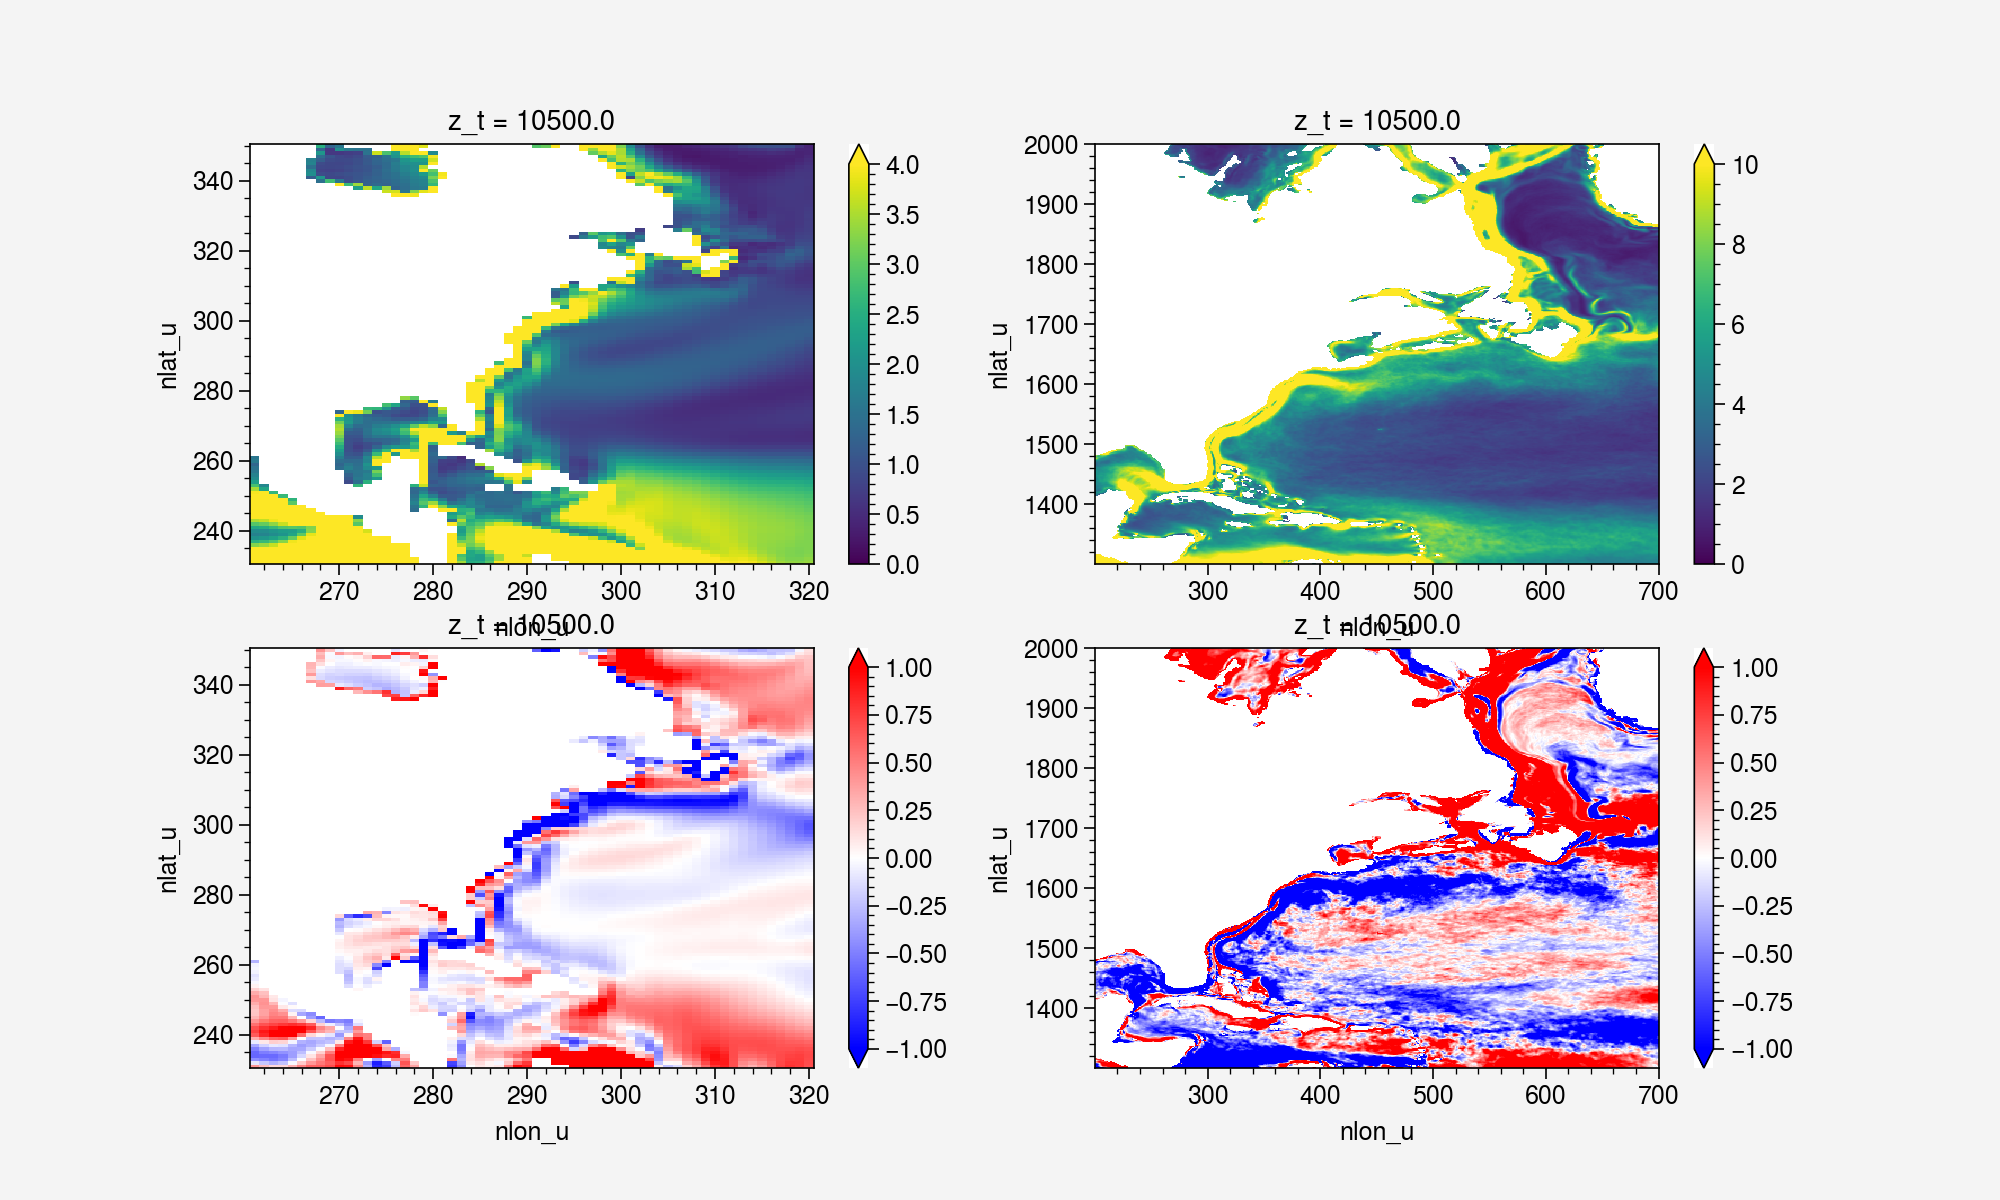

In [34]:
fig, axs = plt.subplots(2,2,figsize=(10,6))
spd_Vag_r_TL.sel(time=slice('2001','2020')).mean('time').plot(ax=axs[0,0], vmin=0, vmax=4)
spd_Vag_r_TH.sel(time=slice('2001','2020')).mean('time').plot(ax=axs[0,1], vmin=0, vmax=10)
(spd_Vag_r_TL.sel(time=slice('2081','2100')).mean('time') - spd_Vag_r_TL.sel(time=slice('2001','2020')).mean('time')).plot(ax=axs[1,0], vmin=-1, vmax=1, cmap='bwr')
(spd_Vag_r_TH.sel(time=slice('2081','2100')).mean('time') - spd_Vag_r_TH.sel(time=slice('2001','2020')).mean('time')).plot(ax=axs[1,1], vmin=-1, vmax=1, cmap='bwr')

In [36]:
fig, axs = plt.subplots(3,2,figsize=(10,8))
(spd_Vag_r_t1var_TL).plot(ax=axs[0,0], cmap='viridis', vmin=0, vmax=5)
(spd_Vag_r_t1var_TH).plot(ax=axs[0,1], cmap='viridis', vmin=0, vmax=20)
(spd_Vag_r_t2var_TL).plot(ax=axs[1,0], cmap='viridis', vmin=0, vmax=5)
(spd_Vag_r_t2var_TH).plot(ax=axs[1,1], cmap='viridis', vmin=0, vmax=20)
(spd_Vag_r_t2var_TL-spd_Vag_r_t1var_TL).plot(ax=axs[2,0], cmap='bwr', vmin=-8, vmax=8)
(spd_Vag_r_t2var_TH-spd_Vag_r_t1var_TH).plot(ax=axs[2,1], cmap='bwr', vmin=-8, vmax=8)

# make pics

In [40]:
# need lat and lon (no masks over lands)
grid_t12, xds_t12 = pop_tools.to_xgcm_grid_dataset(ds_t12)
xds_t12
xds_r_t12 = xds_t12.isel(nlon_u=slice(nlon1_r_t12, nlon2_r_t12), nlat_u=slice(nlat1_r_t12, nlat2_r_t12))

grid_g16, xds_g16 = pop_tools.to_xgcm_grid_dataset(ds_g16)
xds_g16
xds_r_g16 = xds_g16.isel(nlon_u=slice(nlon1_r_g16, nlon2_r_g16), nlat_u=slice(nlat1_r_g16, nlat2_r_g16))

pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

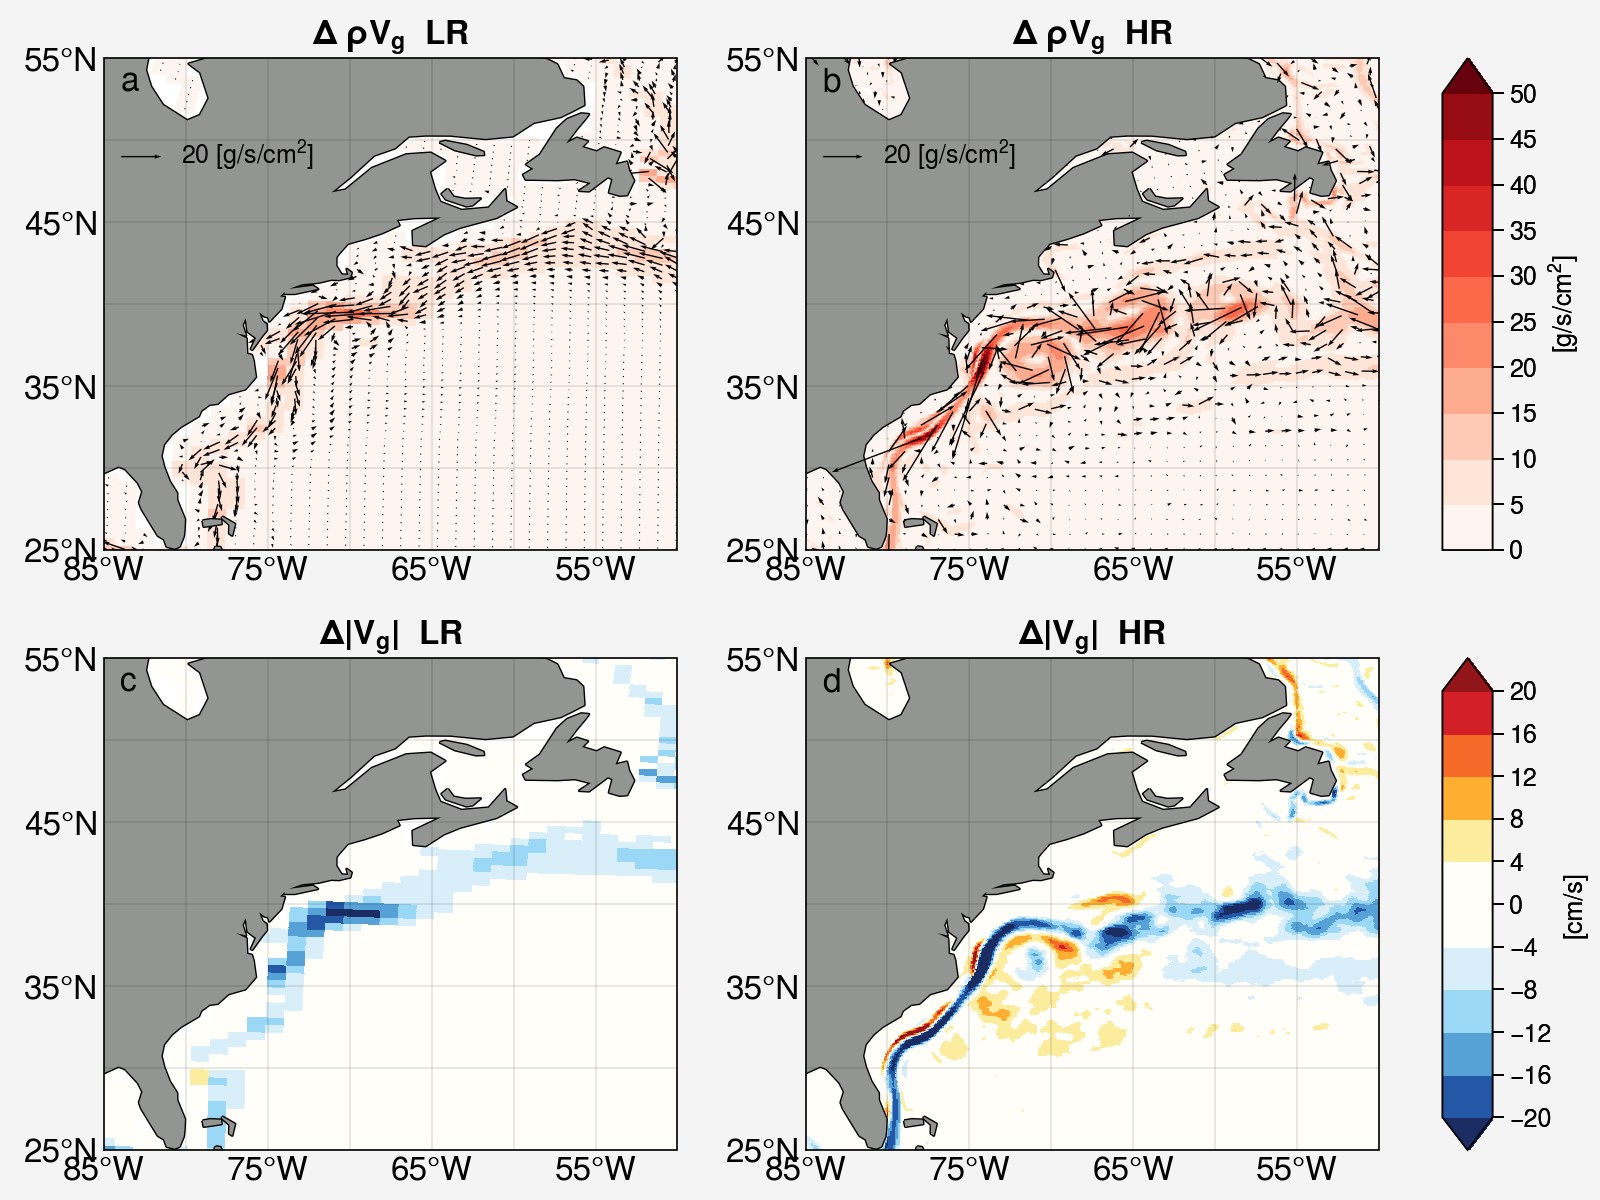

In [39]:
# # Fig 1 Vg*PD
# fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

# spd_UgPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UgPD_z1_r_dt_TLmCL**2+VgPD_z1_r_dt_TLmCL**2)
# m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UgPD_z1_r_dt_TLmCL, 
#                         levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
# q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UgPD_z1_r_dt_TLmCL, VgPD_z1_r_dt_TLmCL,
#                       transform=pc, scale=100, scale_units='inches')
# axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,0].format(land=True, landcolor='grey')
# axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,0].xaxis.set_major_formatter(lon_formatter)
# axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,0].yaxis.set_major_formatter(lat_formatter)
# axs[0,0].set_title(r'$\Delta$ $\rho V_{g}$  LR', fontsize=12, fontweight='bold')
# axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # # add colorbar
# # cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

# spd_UgPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UgPD_z1_r_dt_THmCH**2+VgPD_z1_r_dt_THmCH**2)
# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UgPD_z1_r_dt_THmCH, 
#                         levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
# q01 = axs[0,1].quiver(xds_r_t12.ULONG[::10,::10], xds_r_t12.ULAT[::10,::10], 
#                 UgPD_z1_r_dt_THmCH[::10,::10], VgPD_z1_r_dt_THmCH[::10, ::10], transform=pc, scale=100, scale_units='inches')
# q01.set_zorder(2)
# axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
# axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,1].format(land=True, landcolor='grey')
# axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,1].xaxis.set_major_formatter(lon_formatter)
# axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,1].yaxis.set_major_formatter(lat_formatter)
# axs[0,1].set_title(r'$\Delta$ $\rho V_{g}$  HR', fontsize=12, fontweight='bold')
# axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

# cut=-0.1
# m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_Vg_r_dt_TLmCL, 
#                         levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# # axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[1,0].format(land=True, landcolor='grey')
# axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[1,0].xaxis.set_major_formatter(lon_formatter)
# axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[1,0].yaxis.set_major_formatter(lat_formatter)
# axs[1,0].set_title(r'$\Delta |V_{g}|$  LR', fontsize=12, fontweight='bold')
# axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # # add colorbar
# # cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


# m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_Vg_r_dt_THmCH, 
#                         levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[1,1].format(land=True, landcolor='grey')
# axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[1,1].xaxis.set_major_formatter(lon_formatter)
# axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[1,1].yaxis.set_major_formatter(lat_formatter)
# axs[1,1].set_title(r'$\Delta |V_{g}|$  HR', fontsize=12, fontweight='bold')
# axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[1,1].colorbar(m11,loc='r', label='[cm/s]',width='2em')

# # fig1.savefig(pic1,bbox_inches='tight')

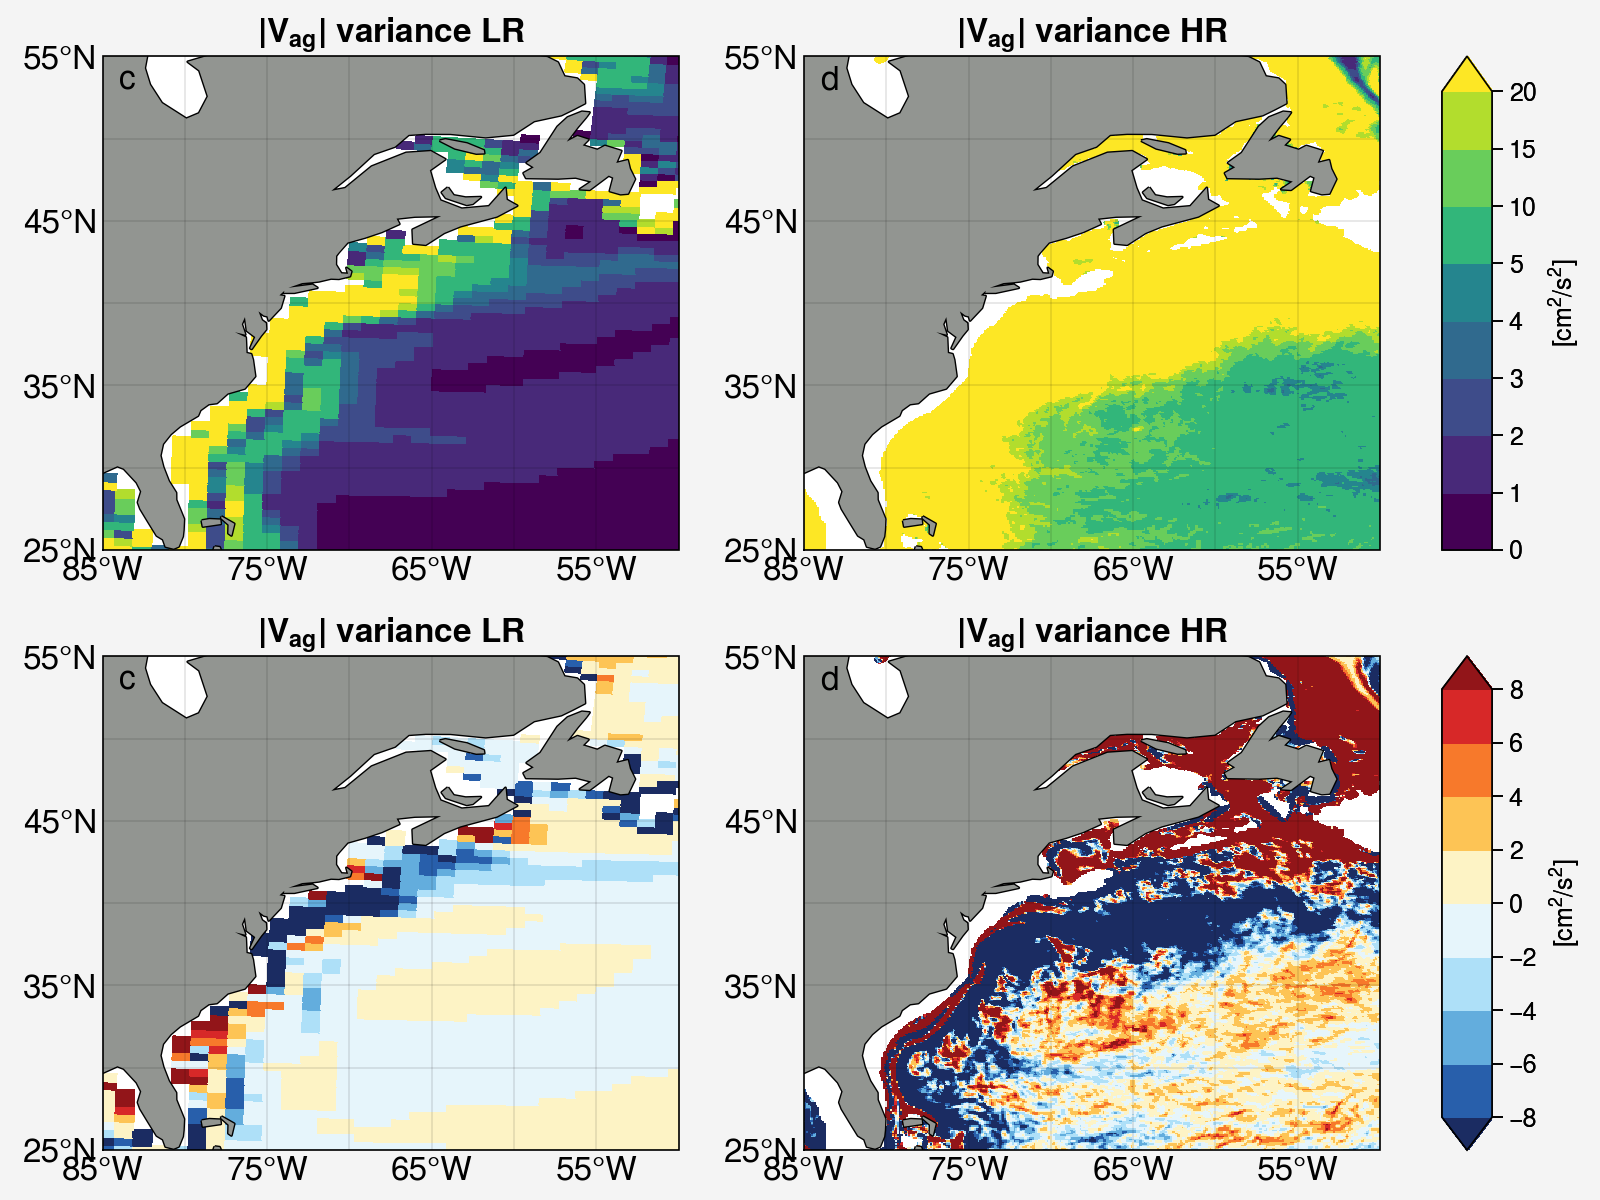

In [43]:
# Fig 2 Vag*PD
fig2, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

# spd_UagPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UagPD_z1_r_dt_TLmCL**2+VagPD_z1_r_dt_TLmCL**2)
# m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UagPD_z1_r_dt_TLmCL, 
#                         levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# # q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UagPD_z1_r_dt_TLmCL, VagPD_z1_r_dt_TLmCL, 
# #                       transform=pc, scale=20, scale_units='inches',headwidth=3.5)
# # axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,0].format(land=True, landcolor='grey')
# axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,0].xaxis.set_major_formatter(lon_formatter)
# axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,0].yaxis.set_major_formatter(lat_formatter)
# axs[0,0].set_title(r'$\Delta$ $\rho V_{ag}$  LR', fontsize=12, fontweight='bold')
# axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # # add colorbar
# # cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


# spd_UagPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UagPD_z1_r_dt_THmCH**2+VagPD_z1_r_dt_THmCH**2)
# # spd_UagPD_z1_r_dt_TH = xr.ufuncs.sqrt(UagPD_z1_r_dt_TH**2+VagPD_z1_r_dt_TH**2)
# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UagPD_z1_r_dt_THmCH, 
#                         levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# # --- too many quivers, hard to read color ---
# # q11 = axs[1,1].quiver(xds_r_t12.ULONG[::5,::5], xds_r_t12.ULAT[::5,::5], 
# #                 UagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), 
# #                 VagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# # --------------------------------------------
# # --- too many quivers, hard to read color ---
# # q11 = axs[1,1].quiver(xds_r_t12.ULONG, xds_r_t12.ULAT, 
# #                 UagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), 
# #                 VagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# # --------------------------------------------
# q01 = axs[0,1].quiver(xds_r_t12.ULONG[5::10,5::10], xds_r_t12.ULAT[5::10,5::10], 
#                       UagPD_z1_r_dt_THmCH[5::10,5::10], VagPD_z1_r_dt_THmCH[5::10,5::10], 
#                       transform=pc, scale=20, scale_units='inches',headwidth=3.5)
# q01.set_zorder(2)
# axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,1].format(land=True, landcolor='grey')
# axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,1].xaxis.set_major_formatter(lon_formatter)
# axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,1].yaxis.set_major_formatter(lat_formatter)
# axs[0,1].set_title(r'$\Delta$ $\rho V_{ag}$  HR', fontsize=12, fontweight='bold')
# axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

# m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, np.log10(spd_Vag_r_t1var_TL), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, (spd2_Vag_r_t1av_TL), 
                        levels=[0,1,2,3,4,5,10,15,20], transform=pc, cmap="viridis", extend='max')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, (spd2_Vag_r_t1av_TH), 
                        levels=[0,1,2,3,4,5,10,15,20], transform=pc, cmap="viridis", extend='max')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[$cm^2$/$s^2$]',width='2em')

cut=-0.
m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, (spd2_Vag_r_t2av_TL - spd2_Vag_r_t1av_TL), 
                        levels=np.arange(-8,8.01,2), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, (spd2_Vag_r_t2av_TH - spd2_Vag_r_t1av_TH), 
                        levels=np.arange(-8,8.01,2), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label=r'[$cm^2$/$s^2$]',width='2em')
# cb = axs[0,1].colorbar(m01,loc='r', label=r'[$cm^2$/$s^2$]',width='2em', ticks=np.arange(0,1.51,0.25), 
#                        ticklabels=[r'$10^0$',r'$10^{0.25}$',r'$10^{0.5}$',r'$10^{0.75}$',r'$10^{1}$',r'$10^{1.25}$',r'$10^{1.5}$'])
# fig2.savefig(pic2,bbox_inches='tight')

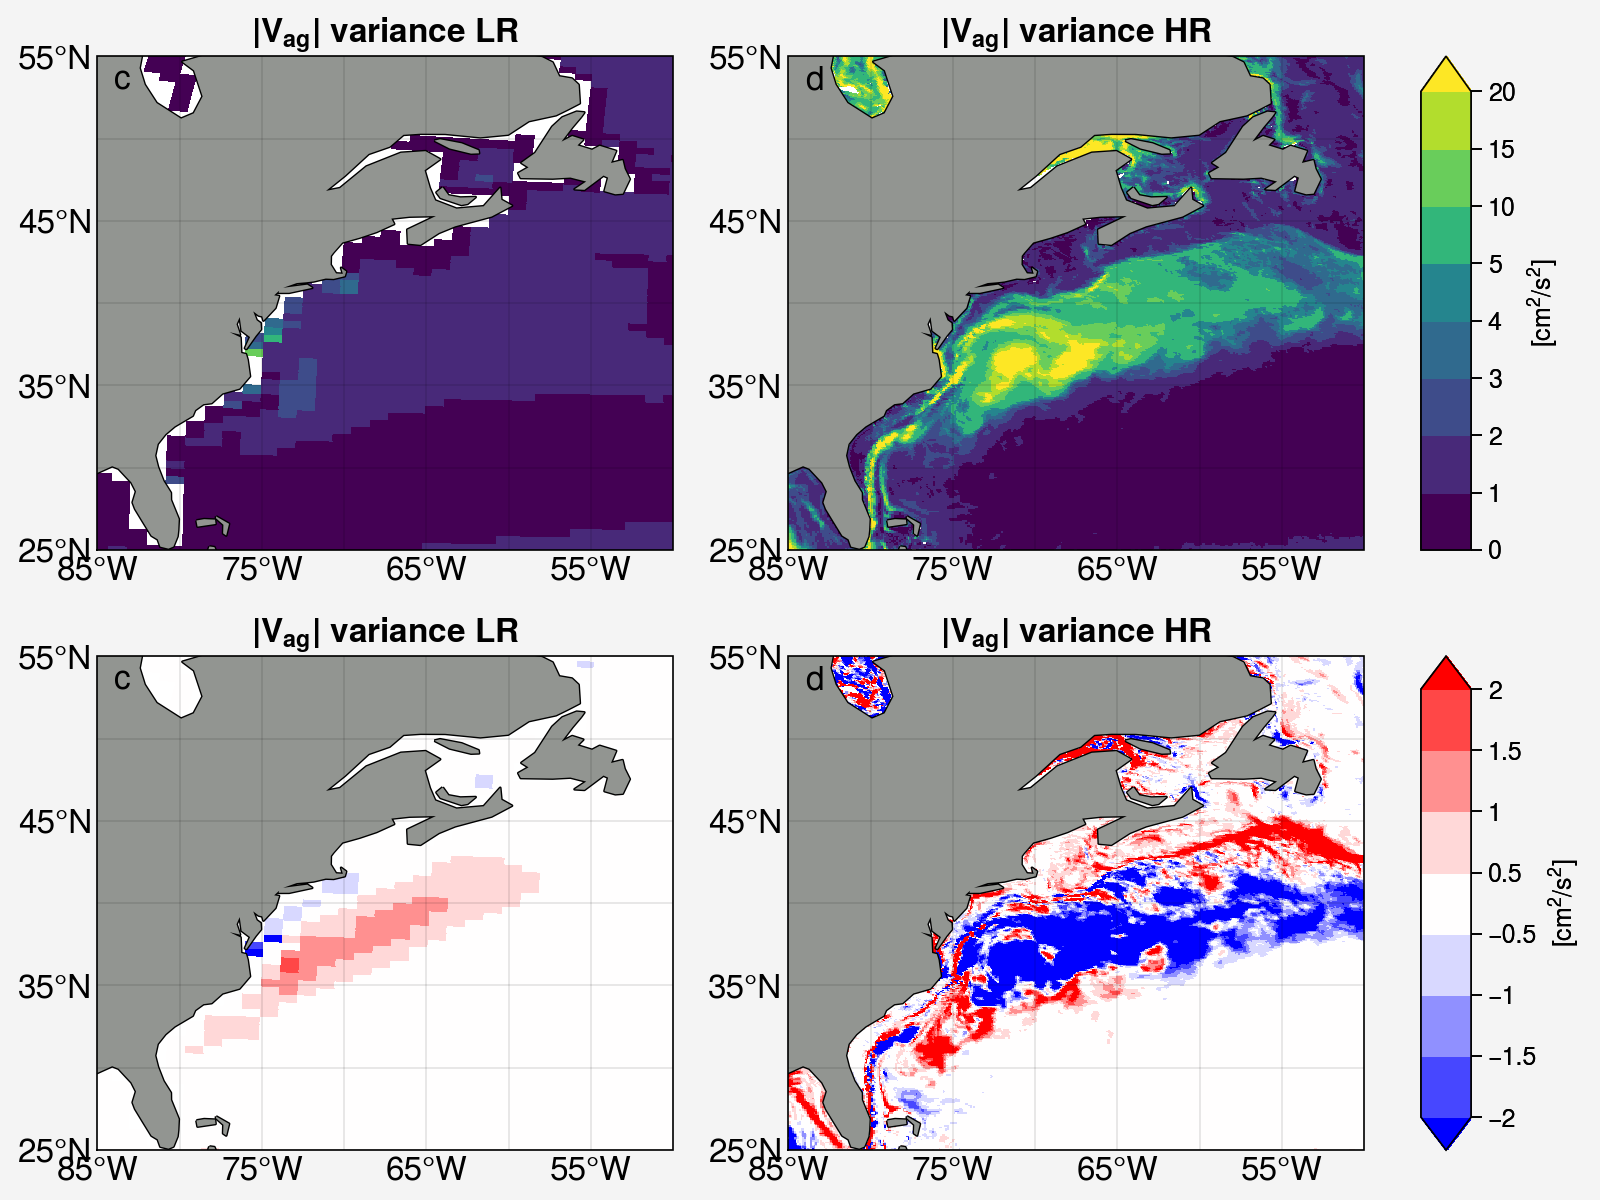

In [84]:
# Fig 2 Vag*PD
fig2, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

# spd_UagPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UagPD_z1_r_dt_TLmCL**2+VagPD_z1_r_dt_TLmCL**2)
# m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UagPD_z1_r_dt_TLmCL, 
#                         levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# # q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UagPD_z1_r_dt_TLmCL, VagPD_z1_r_dt_TLmCL, 
# #                       transform=pc, scale=20, scale_units='inches',headwidth=3.5)
# # axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,0].format(land=True, landcolor='grey')
# axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,0].xaxis.set_major_formatter(lon_formatter)
# axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,0].yaxis.set_major_formatter(lat_formatter)
# axs[0,0].set_title(r'$\Delta$ $\rho V_{ag}$  LR', fontsize=12, fontweight='bold')
# axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # # add colorbar
# # cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


# spd_UagPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UagPD_z1_r_dt_THmCH**2+VagPD_z1_r_dt_THmCH**2)
# # spd_UagPD_z1_r_dt_TH = xr.ufuncs.sqrt(UagPD_z1_r_dt_TH**2+VagPD_z1_r_dt_TH**2)
# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UagPD_z1_r_dt_THmCH, 
#                         levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# # --- too many quivers, hard to read color ---
# # q11 = axs[1,1].quiver(xds_r_t12.ULONG[::5,::5], xds_r_t12.ULAT[::5,::5], 
# #                 UagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), 
# #                 VagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# # --------------------------------------------
# # --- too many quivers, hard to read color ---
# # q11 = axs[1,1].quiver(xds_r_t12.ULONG, xds_r_t12.ULAT, 
# #                 UagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), 
# #                 VagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# # --------------------------------------------
# q01 = axs[0,1].quiver(xds_r_t12.ULONG[5::10,5::10], xds_r_t12.ULAT[5::10,5::10], 
#                       UagPD_z1_r_dt_THmCH[5::10,5::10], VagPD_z1_r_dt_THmCH[5::10,5::10], 
#                       transform=pc, scale=20, scale_units='inches',headwidth=3.5)
# q01.set_zorder(2)
# axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,1].format(land=True, landcolor='grey')
# axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,1].xaxis.set_major_formatter(lon_formatter)
# axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,1].yaxis.set_major_formatter(lat_formatter)
# axs[0,1].set_title(r'$\Delta$ $\rho V_{ag}$  HR', fontsize=12, fontweight='bold')
# axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

# m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, np.log10(spd_Vag_r_t1var_TL), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, (spd_Vag_r_t1var_TL), 
                        levels=[0,1,2,3,4,5,10,15,20], transform=pc, cmap="viridis", extend='max')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, (spd_Vag_r_t1var_TH), 
                        levels=[0,1,2,3,4,5,10,15,20], transform=pc, cmap="viridis", extend='max')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[$cm^2$/$s^2$]',width='2em')

cut=-0.1
m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, (spd_Vag_r_t2var_TL - spd_Vag_r_t1var_TL), 
                        levels=[-2,-1.5,-1,-0.5,0.5,1,1.5,2], transform=pc, cmap="bwr", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, (spd_Vag_r_t2var_TH - spd_Vag_r_t1var_TH), 
                        levels=[-2,-1.5,-1,-0.5,0.5,1,1.5,2], transform=pc, cmap="bwr", cmap_kw={'cut': cut}, extend='both')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label=r'[$cm^2$/$s^2$]',width='2em')
# cb = axs[0,1].colorbar(m01,loc='r', label=r'[$cm^2$/$s^2$]',width='2em', ticks=np.arange(0,1.51,0.25), 
#                        ticklabels=[r'$10^0$',r'$10^{0.25}$',r'$10^{0.5}$',r'$10^{0.75}$',r'$10^{1}$',r'$10^{1.25}$',r'$10^{1.5}$'])
# fig2.savefig(pic2,bbox_inches='tight')

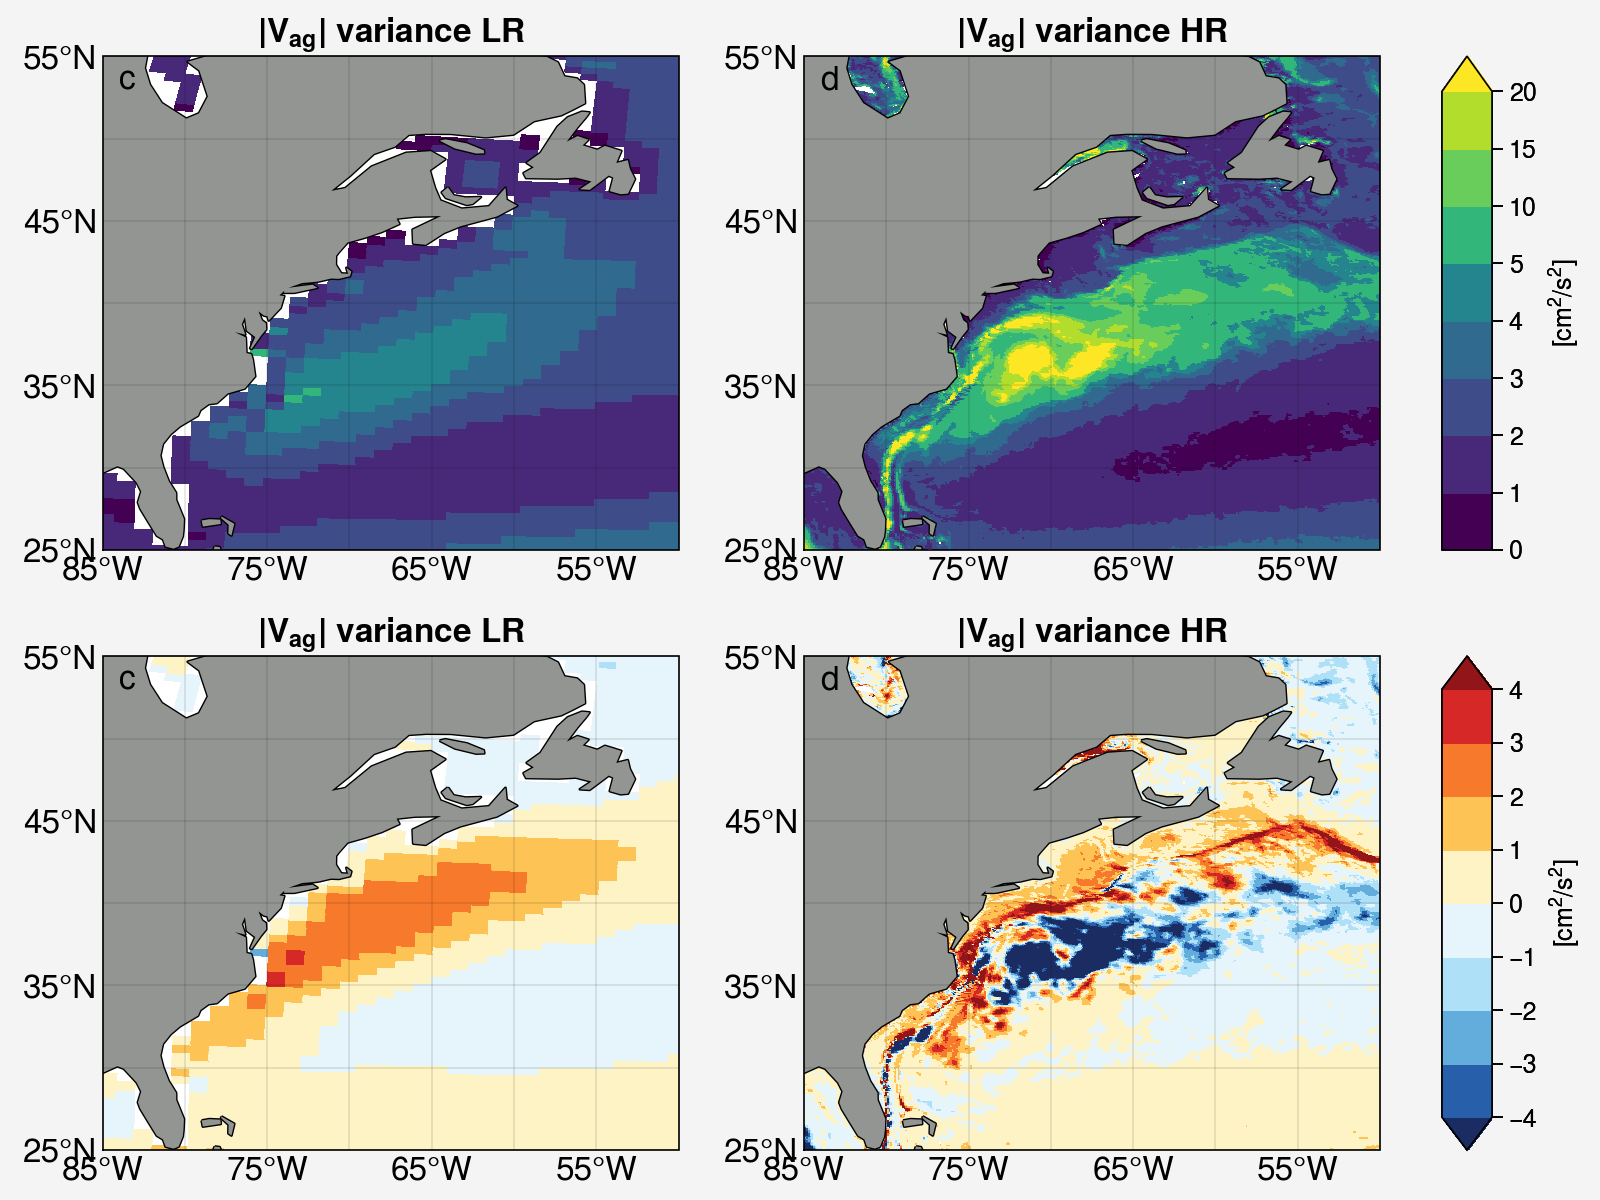

In [54]:
# Fig 2 Vag*PD
fig2, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

# spd_UagPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UagPD_z1_r_dt_TLmCL**2+VagPD_z1_r_dt_TLmCL**2)
# m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UagPD_z1_r_dt_TLmCL, 
#                         levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# # q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UagPD_z1_r_dt_TLmCL, VagPD_z1_r_dt_TLmCL, 
# #                       transform=pc, scale=20, scale_units='inches',headwidth=3.5)
# # axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,0].format(land=True, landcolor='grey')
# axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,0].xaxis.set_major_formatter(lon_formatter)
# axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,0].yaxis.set_major_formatter(lat_formatter)
# axs[0,0].set_title(r'$\Delta$ $\rho V_{ag}$  LR', fontsize=12, fontweight='bold')
# axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # # add colorbar
# # cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


# spd_UagPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UagPD_z1_r_dt_THmCH**2+VagPD_z1_r_dt_THmCH**2)
# # spd_UagPD_z1_r_dt_TH = xr.ufuncs.sqrt(UagPD_z1_r_dt_TH**2+VagPD_z1_r_dt_TH**2)
# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UagPD_z1_r_dt_THmCH, 
#                         levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# # --- too many quivers, hard to read color ---
# # q11 = axs[1,1].quiver(xds_r_t12.ULONG[::5,::5], xds_r_t12.ULAT[::5,::5], 
# #                 UagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), 
# #                 VagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# # --------------------------------------------
# # --- too many quivers, hard to read color ---
# # q11 = axs[1,1].quiver(xds_r_t12.ULONG, xds_r_t12.ULAT, 
# #                 UagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), 
# #                 VagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# # --------------------------------------------
# q01 = axs[0,1].quiver(xds_r_t12.ULONG[5::10,5::10], xds_r_t12.ULAT[5::10,5::10], 
#                       UagPD_z1_r_dt_THmCH[5::10,5::10], VagPD_z1_r_dt_THmCH[5::10,5::10], 
#                       transform=pc, scale=20, scale_units='inches',headwidth=3.5)
# q01.set_zorder(2)
# axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,1].format(land=True, landcolor='grey')
# axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,1].xaxis.set_major_formatter(lon_formatter)
# axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,1].yaxis.set_major_formatter(lat_formatter)
# axs[0,1].set_title(r'$\Delta$ $\rho V_{ag}$  HR', fontsize=12, fontweight='bold')
# axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

# m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, np.log10(spd_Vag_r_t1var_TL), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, (spd_Vag_r_t1var_TL), 
                        levels=[0,1,2,3,4,5,10,15,20], transform=pc, cmap="viridis", extend='max')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, (spd_Vag_r_t1var_TH), 
                        levels=[0,1,2,3,4,5,10,15,20], transform=pc, cmap="viridis", extend='max')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[$cm^2$/$s^2$]',width='2em')

m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, (spd_Vag_r_t2var_TL - spd_Vag_r_t1var_TL), 
                        levels=np.arange(-4,4.01,1), transform=pc, cmap="ColdHot", extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

# m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
#                         levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, (spd_Vag_r_t2var_TH - spd_Vag_r_t1var_TH), 
                        levels=np.arange(-4,4.01,1), transform=pc, cmap="ColdHot", extend='both')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label=r'[$cm^2$/$s^2$]',width='2em')
# cb = axs[0,1].colorbar(m01,loc='r', label=r'[$cm^2$/$s^2$]',width='2em', ticks=np.arange(0,1.51,0.25), 
#                        ticklabels=[r'$10^0$',r'$10^{0.25}$',r'$10^{0.5}$',r'$10^{0.75}$',r'$10^{1}$',r'$10^{1.25}$',r'$10^{1.5}$'])
# fig2.savefig(pic2,bbox_inches='tight')

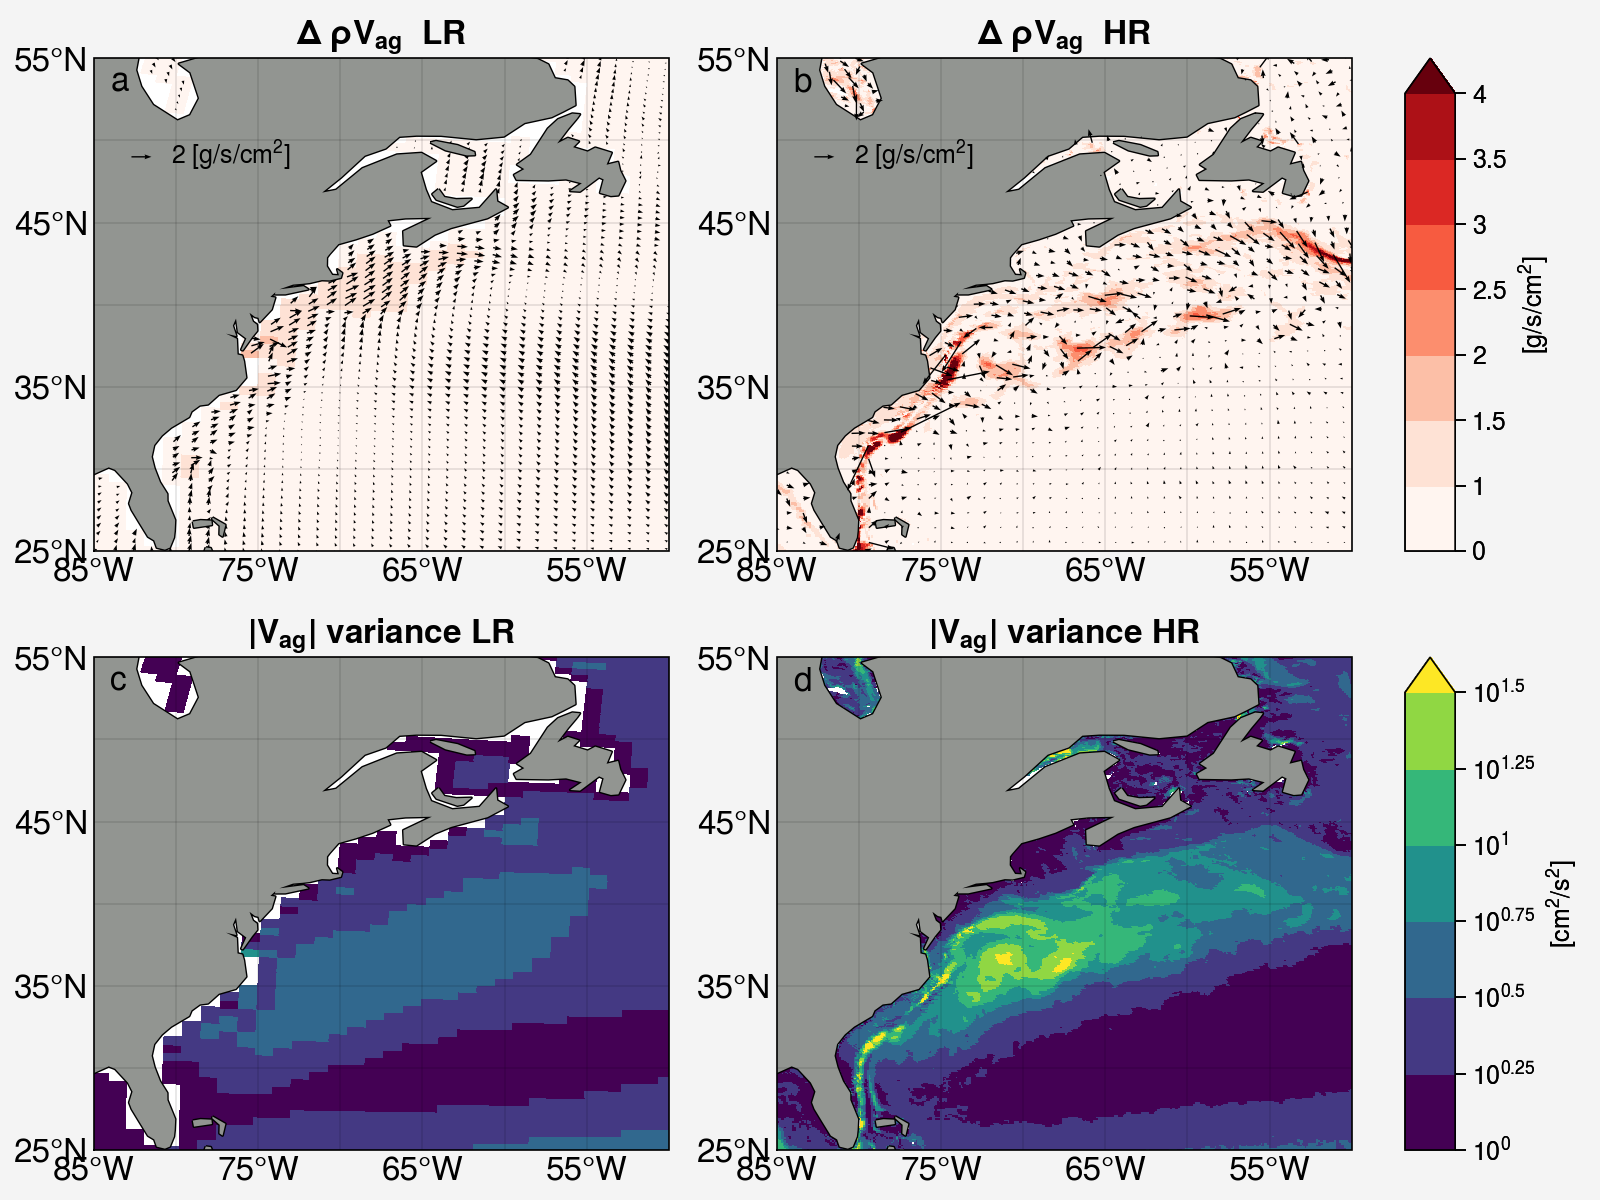

In [40]:
# Fig 2 Vag*PD
fig2, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')
# np.arange(0, 4.01, 0.5)
spd_UagPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UagPD_z1_r_dt_TLmCL**2+VagPD_z1_r_dt_TLmCL**2)
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UagPD_z1_r_dt_TLmCL, 
                        levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UagPD_z1_r_dt_TLmCL, VagPD_z1_r_dt_TLmCL, 
                      transform=pc, scale=20, scale_units='inches',headwidth=3.5)
axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta$ $\rho V_{ag}$  LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


spd_UagPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UagPD_z1_r_dt_THmCH**2+VagPD_z1_r_dt_THmCH**2)
# spd_UagPD_z1_r_dt_TH = xr.ufuncs.sqrt(UagPD_z1_r_dt_TH**2+VagPD_z1_r_dt_TH**2)
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UagPD_z1_r_dt_THmCH, 
                        levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# --- too many quivers, hard to read color ---
# q11 = axs[1,1].quiver(xds_r_t12.ULONG[::5,::5], xds_r_t12.ULAT[::5,::5], 
#                 UagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), 
#                 VagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# --------------------------------------------
# --- too many quivers, hard to read color ---
# q11 = axs[1,1].quiver(xds_r_t12.ULONG, xds_r_t12.ULAT, 
#                 UagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), 
#                 VagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# --------------------------------------------
q01 = axs[0,1].quiver(xds_r_t12.ULONG[5::10,5::10], xds_r_t12.ULAT[5::10,5::10], 
                      UagPD_z1_r_dt_THmCH[5::10,5::10], VagPD_z1_r_dt_THmCH[5::10,5::10], 
                      transform=pc, scale=20, scale_units='inches',headwidth=3.5)
q01.set_zorder(2)
axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$\Delta$ $\rho V_{ag}$  HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, np.log10(spd_Vag_r_t1var_TL), 
                        levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
                        levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label=r'[$cm^2$/$s^2$]',width='2em', ticks=np.arange(0,1.51,0.25), 
                       ticklabels=[r'$10^0$',r'$10^{0.25}$',r'$10^{0.5}$',r'$10^{0.75}$',r'$10^{1}$',r'$10^{1.25}$',r'$10^{1.5}$'])
# fig2.savefig(pic2,bbox_inches='tight')

/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/dask/array/core.py:1527: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/dask/array/core.py:1527: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


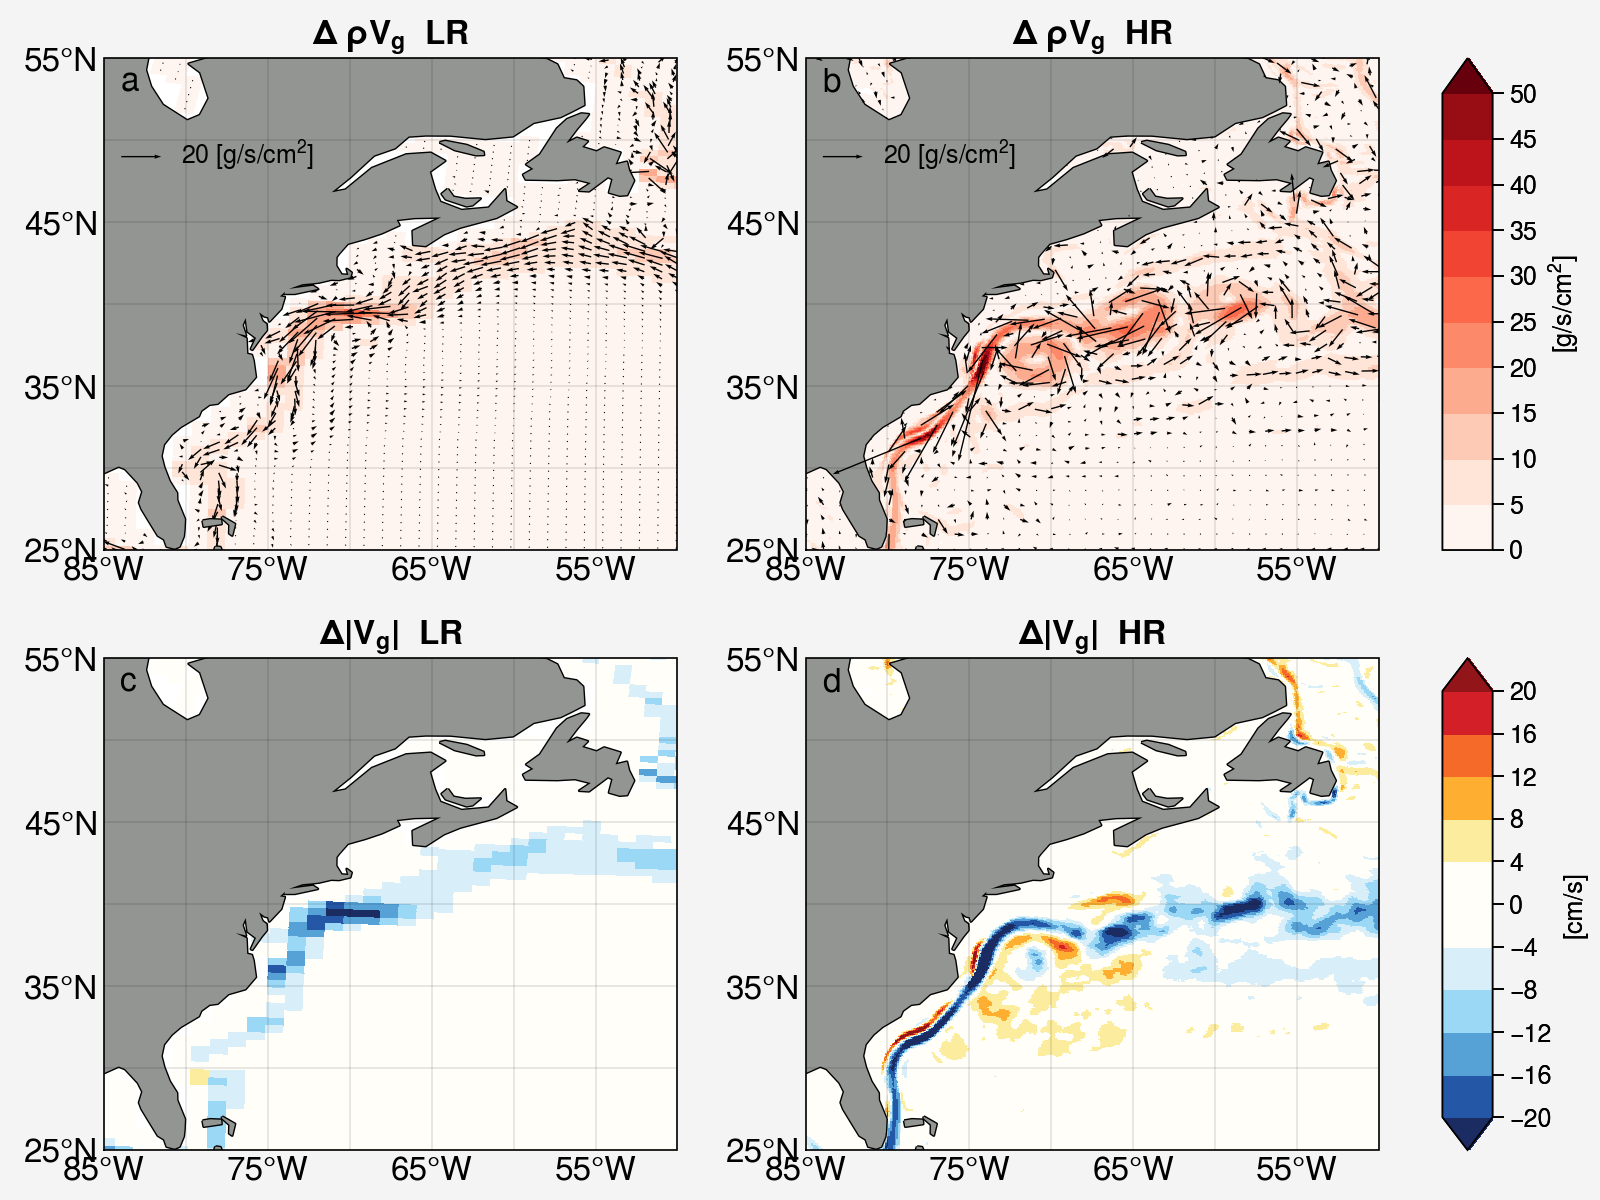

In [58]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# Fig 1 Vg*PD
fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

spd_UgPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UgPD_z1_r_dt_TLmCL**2+VgPD_z1_r_dt_TLmCL**2)
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UgPD_z1_r_dt_TLmCL, 
                        levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UgPDr_z1_r_dt_TLmCL, VgPDr_z1_r_dt_TLmCL,
                      transform=pc, scale=100, scale_units='inches')
axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta$ $\rho V_{g}$  LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

spd_UgPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UgPD_z1_r_dt_THmCH**2+VgPD_z1_r_dt_THmCH**2)
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UgPD_z1_r_dt_THmCH, 
                        levels=np.arange(0, 50.01, 5), transform=pc, cmap="Reds", extend='max')
q01 = axs[0,1].quiver(xds_r_t12.ULONG[::10,::10], xds_r_t12.ULAT[::10,::10], 
                UgPDr_z1_r_dt_THmCH[::10,::10], VgPDr_z1_r_dt_THmCH[::10, ::10], transform=pc, scale=100, scale_units='inches')
q01.set_zorder(2)
axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=20, label=r'20 [g/s/$cm^2$]', labelpos='E')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$\Delta$ $\rho V_{g}$  HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

cut=-0.1
m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_Vg_r_dt_TLmCL, 
                        levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$\Delta |V_{g}|$  LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_Vg_r_dt_THmCH, 
                        levels=np.arange(-20,20+0.1,4), transform=pc, cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$\Delta |V_{g}|$  HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label='[cm/s]',width='2em')

# fig1.savefig(pic1,bbox_inches='tight')

/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/dask/array/core.py:1527: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,
/ihesp/software/conda/envs/xroms_unstable_daskpr/lib/python3.7/site-packages/dask/array/core.py:1527: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


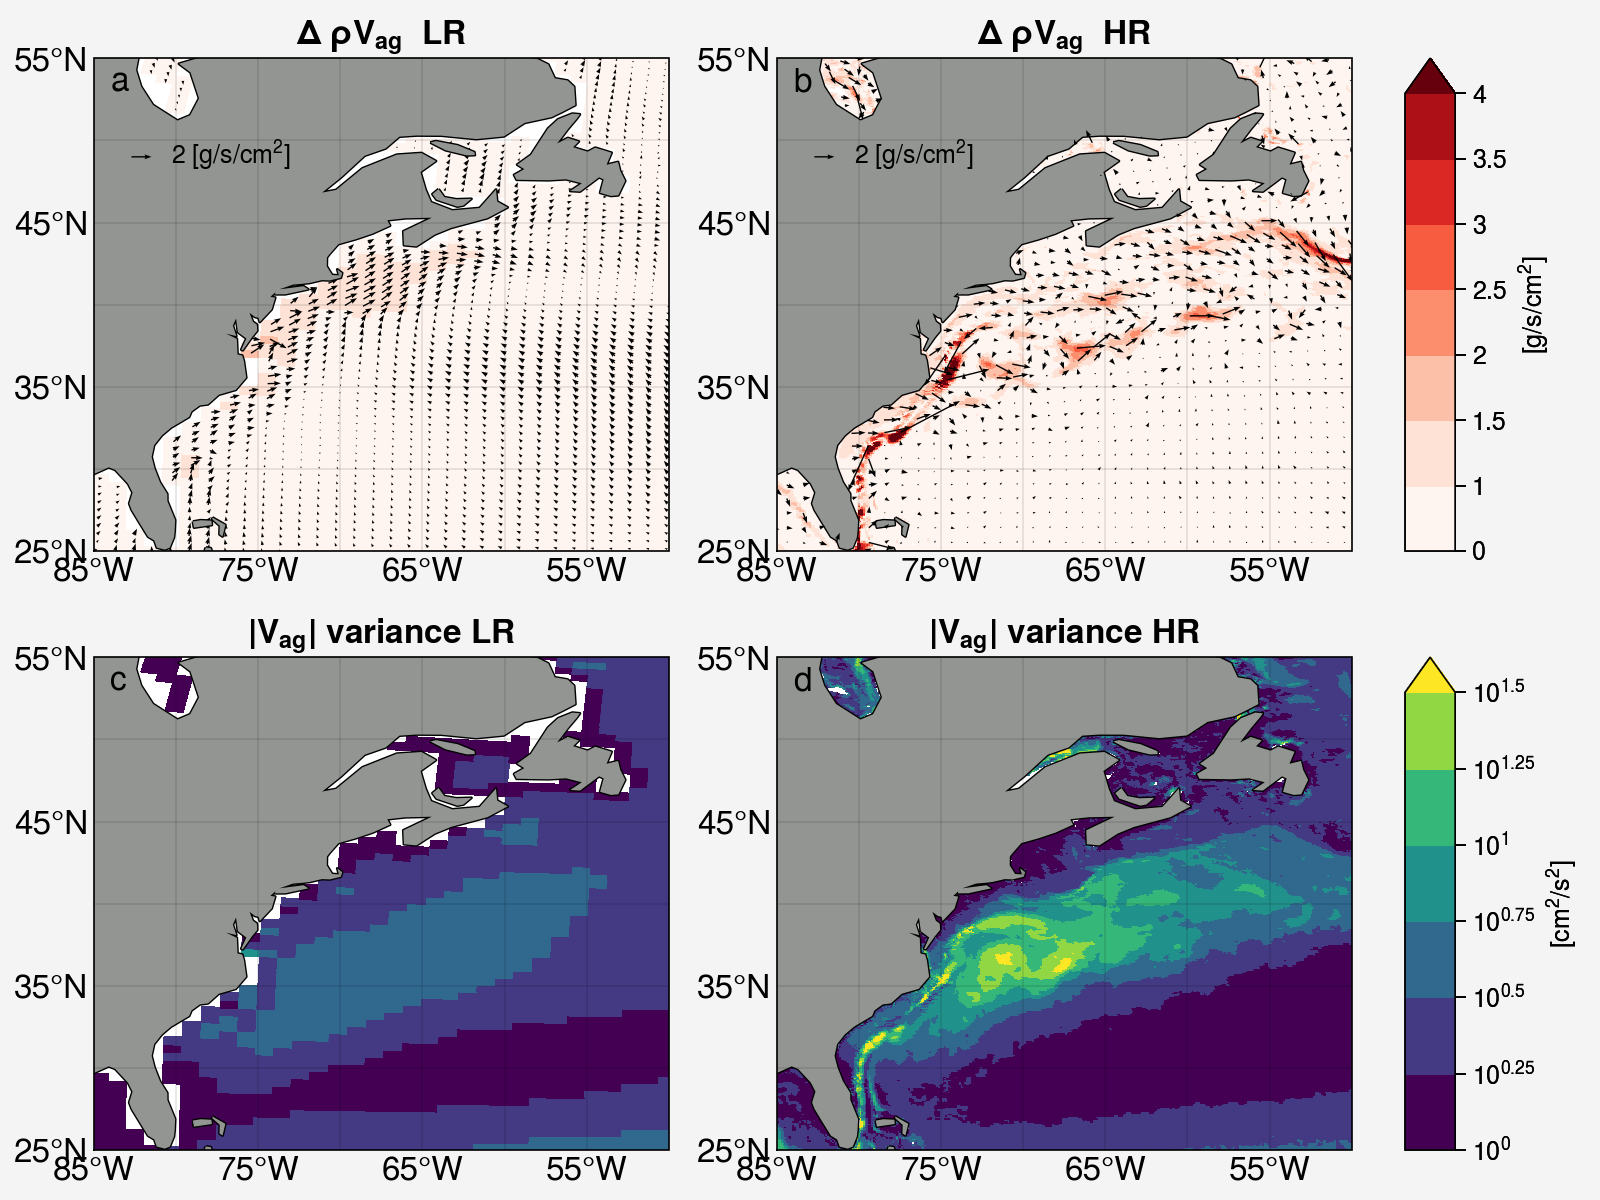

In [55]:
# Fig 2 Vag*PD
fig2, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')
# np.arange(0, 4.01, 0.5)
spd_UagPD_z1_r_dt_TLmCL = xr.ufuncs.sqrt(UagPD_z1_r_dt_TLmCL**2+VagPD_z1_r_dt_TLmCL**2)
m00=axs[0,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, spd_UagPD_z1_r_dt_TLmCL, 
                        levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
q00 = axs[0,0].quiver(xds_r_g16.ULONG, xds_r_g16.ULAT, UagPDr_z1_r_dt_TLmCL, VagPDr_z1_r_dt_TLmCL, 
                      transform=pc, scale=20, scale_units='inches',headwidth=3.5)
axs[0,0].quiverkey(q00, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
# axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$\Delta$ $\rho V_{ag}$  LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')


spd_UagPD_z1_r_dt_THmCH = xr.ufuncs.sqrt(UagPD_z1_r_dt_THmCH**2+VagPD_z1_r_dt_THmCH**2)
# spd_UagPD_z1_r_dt_TH = xr.ufuncs.sqrt(UagPD_z1_r_dt_TH**2+VagPD_z1_r_dt_TH**2)
m01=axs[0,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, spd_UagPD_z1_r_dt_THmCH, 
                        levels=[0,1,1.5,2,2.5,3,3.5,4], transform=pc, cmap="Reds", extend='max')
# --- too many quivers, hard to read color ---
# q11 = axs[1,1].quiver(xds_r_t12.ULONG[::5,::5], xds_r_t12.ULAT[::5,::5], 
#                 UagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), 
#                 VagPD_z1_r_dt_TH[::5,::5].where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# --------------------------------------------
# --- too many quivers, hard to read color ---
# q11 = axs[1,1].quiver(xds_r_t12.ULONG, xds_r_t12.ULAT, 
#                 UagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), 
#                 VagPD_z1_r_dt_TH.where(spd_UagPD_z1_r_dt_TH>0.02), transform=pc, scale=0.2, scale_units='inches')
# --------------------------------------------
q01 = axs[0,1].quiver(xds_r_t12.ULONG[5::10,5::10], xds_r_t12.ULAT[5::10,5::10], 
                      UagPDr_z1_r_dt_THmCH[5::10,5::10], VagPDr_z1_r_dt_THmCH[5::10,5::10], 
                      transform=pc, scale=20, scale_units='inches',headwidth=3.5)
q01.set_zorder(2)
axs[0,1].quiverkey(q01, X=0.1, Y=0.8, U=2, label=r'2 [g/s/$cm^2$]', labelpos='E')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$\Delta$ $\rho V_{ag}$  HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=12)
# add colorbar
cb = axs[0,1].colorbar(m01,loc='r', label=r'[g/s/$cm^2$]',width='2em')

m10=axs[1,0].pcolormesh(xds_r_g16.ULONG, xds_r_g16.ULAT, np.log10(spd_Vag_r_t1var_TL), 
                        levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$|V_{ag}|$ variance LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=12)
# # add colorbar
# cb = axs[0,0].colorbar(m00,loc='r', label='[cm]',width='2em')

m11=axs[1,1].pcolormesh(xds_r_t12.ULONG, xds_r_t12.ULAT, np.log10(spd_Vag_r_t1var_TH), 
                        levels=np.arange(0, 1.5+0.1, 0.25), transform=pc, cmap="viridis", extend='max')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$|V_{ag}|$ variance HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=12)
# add colorbar
cb = axs[1,1].colorbar(m11,loc='r', label=r'[$cm^2$/$s^2$]',width='2em', ticks=np.arange(0,1.51,0.25), 
                       ticklabels=[r'$10^0$',r'$10^{0.25}$',r'$10^{0.5}$',r'$10^{0.75}$',r'$10^{1}$',r'$10^{1.25}$',r'$10^{1.5}$'])
# fig2.savefig(pic2,bbox_inches='tight')